# **AI for Finance: Final Project**
# **Forecasting WTI Crude Oil Spot Prices**

### *Giulio Mattolin 224072*

It is possible to find the data used in this work at the following link: https://drive.google.com/drive/folders/1IuCPNYA_KW7uSsb_8ex47s2Ct3NQStQ-?usp=sharing

To reproduce the results of the neural network, make sure the Runtime Type is set to GPU.

## Import libraries

In [ ]:
!pip install arch

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from arch import arch_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import random

## Download and preprocess data

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Companies data

In [ ]:
portfolio = pd.read_csv('/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/stocks_full.csv')
portfolio.head()

,Date,XOM,SHEL.AS,TOT.TO,BP.L,CVX,MRO,.SP500,VLO,ENI.MI,COP,IOC.NS,RELI.NS,.STOXX
0,1986-11-30,8.65625,5.856601,NaN,112.666554,11.84375,5.341914,249.22,NaN,NaN,NaN,NaN,NaN,NaN
1,1986-12-31,8.76575,5.933176,NaN,121.333212,11.34375,5.436741,242.17,NaN,NaN,NaN,NaN,NaN,NaN
2,1987-01-31,10.34375,6.086327,NaN,128.833204,13.25000,5.879266,274.08,NaN,NaN,NaN,NaN,NaN,NaN
3,1987-02-28,9.79700,6.018260,NaN,127.499872,12.37500,6.037311,284.20,NaN,NaN,NaN,NaN,NaN,NaN
4,1987-03-31,10.71875,6.809539,NaN,152.499847,14.03125,7.112016,291.70,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# format date keeping just the year and month
portfolio['Date'] = pd.to_datetime(portfolio['Date']).dt.strftime("%Y-%m")
portfolio.head()

,Date,XOM,SHEL.AS,TOT.TO,BP.L,CVX,MRO,.SP500,VLO,ENI.MI,COP,IOC.NS,RELI.NS,.STOXX
0,1986-11,8.65625,5.856601,NaN,112.666554,11.84375,5.341914,249.22,NaN,NaN,NaN,NaN,NaN,NaN
1,1986-12,8.76575,5.933176,NaN,121.333212,11.34375,5.436741,242.17,NaN,NaN,NaN,NaN,NaN,NaN
2,1987-01,10.34375,6.086327,NaN,128.833204,13.25000,5.879266,274.08,NaN,NaN,NaN,NaN,NaN,NaN
3,1987-02,9.79700,6.018260,NaN,127.499872,12.37500,6.037311,284.20,NaN,NaN,NaN,NaN,NaN,NaN
4,1987-03,10.71875,6.809539,NaN,152.499847,14.03125,7.112016,291.70,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# make data stationary by computing the percentage change 
portfolio.iloc[:,1:] = portfolio.iloc[:,1:].pct_change()
portfolio.head()

,Date,XOM,SHEL.AS,TOT.TO,BP.L,CVX,MRO,.SP500,VLO,ENI.MI,COP,IOC.NS,RELI.NS,.STOXX
0,1986-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986-12,0.012650,0.013075,NaN,0.076923,-0.042216,0.017751,-0.028288,NaN,NaN,NaN,NaN,NaN,NaN
2,1987-01,0.180019,0.025813,NaN,0.061813,0.168044,0.081395,0.131767,NaN,NaN,NaN,NaN,NaN,NaN
3,1987-02,-0.052858,-0.011184,NaN,-0.010349,-0.066038,0.026882,0.036924,NaN,NaN,NaN,NaN,NaN,NaN
4,1987-03,0.094085,0.131480,NaN,0.196078,0.133838,0.178010,0.026390,NaN,NaN,NaN,NaN,NaN,NaN


### Oil data

In [ ]:
df_1 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/Cushing_OK_WTI_Spot_Price_FOB.csv")
df_1 = df_1.rename(columns={"Cushing OK WTI Spot Price FOB Dollars per Barrel": "WTI Spot Price Dollars per Barrel"})
df_1.head()

,Month,WTI Spot Price Dollars per Barrel
0,Jun 2022,114.84
1,May 2022,109.55
2,Apr 2022,101.78
3,Mar 2022,108.50
4,Feb 2022,91.64


In [ ]:
df_2 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/Europe_Brent_Spot_Price_FOB.csv")
df_2 = df_2.rename(columns={"Europe Brent Spot Price FOB Dollars per Barrel": "Brent Spot Price Dollars per Barrel"})
df_2.head()

,Month,Brent Spot Price Dollars per Barrel
0,Jun 2022,122.71
1,May 2022,113.34
2,Apr 2022,104.58
3,Mar 2022,117.25
4,Feb 2022,97.13


In [ ]:
df_3 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/U.S._Exports_of_Crude_Oil.csv")
df_3.head()

,Month,U.S. Exports of Crude Oil Thousand Barrels
0,Apr 2022,97177
1,Mar 2022,102883
2,Feb 2022,92654
3,Jan 2022,103760
4,Dec 2021,107023


In [ ]:
df_4 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/U.S._Imports_of_Crude_Oil.csv")
df_4.head()

,Month,U.S. Imports of Crude Oil Thousand Barrels
0,Apr 2022,181770
1,Mar 2022,198883
2,Feb 2022,172325
3,Jan 2022,197873
4,Dec 2021,199068


In [ ]:
df_5 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/U.S._Field_Production_of_Crude_Oil.csv")
df_5.head()

,Month,U.S. Field Production of Crude Oil Thousand Barrels
0,Apr 2022,348849
1,Mar 2022,362329
2,Feb 2022,316851
3,Jan 2022,352449
4,Dec 2021,359709


In [ ]:
df_6 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/U.S._Product_Supplied_of_Crude_Oil_and_Petroleum_Products.csv", skiprows=4)
df_6.head()

,Month,U.S. Product Supplied of Crude Oil and Petroleum Products Thousand Barrels
0,Apr 2022,598721
1,Mar 2022,635868
2,Feb 2022,572198
3,Jan 2022,611662
4,Dec 2021,643697


In [ ]:
df_7 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/Cushing_OK_Crude_Oil_Future_Contract_1.csv", skiprows=4)
df_7.head()

,Month,Cushing OK Crude Oil Future Contract 1 Dollars per Barrel
0,Jun 2022,114.34
1,May 2022,109.26
2,Apr 2022,101.64
3,Mar 2022,108.26
4,Feb 2022,91.63


In [ ]:
df_8 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/Cushing_OK_Crude_Oil_Future_Contract_2.csv", skiprows=4)
df_8.head()

,Month,Cushing OK Crude Oil Future Contract 2 Dollars per Barrel
0,Jun 2022,111.87
1,May 2022,107.12
2,Apr 2022,100.72
3,Mar 2022,105.63
4,Feb 2022,90.04


In [ ]:
df_9 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/Cushing_OK_Crude_Oil_Future_Contract_3.csv", skiprows=4)
df_9.head()

,Month,Cushing OK Crude Oil Future Contract 3 Dollars per Barrel
0,Jun 2022,109.20
1,May 2022,104.69
2,Apr 2022,99.60
3,Mar 2022,102.52
4,Feb 2022,88.36


In [ ]:
df_10 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/Cushing_OK_Crude_Oil_Future_Contract_4.csv", skiprows=4)
df_10.head()

,Month,Cushing OK Crude Oil Future Contract 4 Dollars per Barrel
0,Jun 2022,106.71
1,May 2022,102.28
2,Apr 2022,98.31
3,Mar 2022,99.42
4,Feb 2022,86.77


In [ ]:
# merge oil data into one dataframe
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10]
df_oil = reduce(lambda left, right: pd.merge(left, right, on='Month'), dfs)
df_oil.head()

,Month,WTI Spot Price Dollars per Barrel,Brent Spot Price Dollars per Barrel,U.S. Exports of Crude Oil Thousand Barrels,U.S. Imports of Crude Oil Thousand Barrels,U.S. Field Production of Crude Oil Thousand Barrels,U.S. Product Supplied of Crude Oil and Petroleum Products Thousand Barrels,Cushing OK Crude Oil Future Contract 1 Dollars per Barrel,Cushing OK Crude Oil Future Contract 2 Dollars per Barrel,Cushing OK Crude Oil Future Contract 3 Dollars per Barrel,Cushing OK Crude Oil Future Contract 4 Dollars per Barrel
0,Apr 2022,101.78,104.58,97177,181770,348849,598721,101.64,100.72,99.60,98.31
1,Mar 2022,108.50,117.25,102883,198883,362329,635868,108.26,105.63,102.52,99.42
2,Feb 2022,91.64,97.13,92654,172325,316851,572198,91.63,90.04,88.36,86.77
3,Jan 2022,83.22,86.51,103760,197873,352449,611662,82.98,82.15,81.30,80.47
4,Dec 2021,71.71,74.17,107023,199068,359709,643697,71.69,71.46,71.12,70.74


In [ ]:
# change Month column name to Date
# format date keeping just the year and month
# sort data by date from oldest to earliest
df_oil = df_oil.rename(columns={"Month": "Date"})
df_oil['Date'] = pd.to_datetime(df_oil['Date']).dt.strftime("%Y-%m")
df_oil = df_oil.sort_values(by='Date').reset_index(drop=True)
df_oil.head()

,Date,WTI Spot Price Dollars per Barrel,Brent Spot Price Dollars per Barrel,U.S. Exports of Crude Oil Thousand Barrels,U.S. Imports of Crude Oil Thousand Barrels,U.S. Field Production of Crude Oil Thousand Barrels,U.S. Product Supplied of Crude Oil and Petroleum Products Thousand Barrels,Cushing OK Crude Oil Future Contract 1 Dollars per Barrel,Cushing OK Crude Oil Future Contract 2 Dollars per Barrel,Cushing OK Crude Oil Future Contract 3 Dollars per Barrel,Cushing OK Crude Oil Future Contract 4 Dollars per Barrel
0,1987-05,19.44,18.58,2125,134549,258426,496806,19.33,18.98,18.80,18.69
1,1987-06,20.07,18.86,3468,144197,248356,504892,19.99,19.64,19.49,19.41
2,1987-07,21.34,19.86,4616,164131,255782,530502,21.33,20.92,20.71,20.60
3,1987-08,20.31,18.98,4380,170802,254508,506741,20.23,20.00,19.89,19.83
4,1987-09,19.53,18.31,3478,153312,246163,500097,19.52,19.32,19.22,19.17


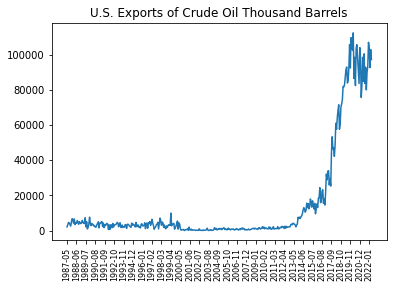

In [ ]:
plt.plot(df_oil['Date'], df_oil['U.S. Exports of Crude Oil Thousand Barrels'])
plt.xticks(np.arange(0, len(df_oil)+1, 13), rotation = 90, fontsize=8)
plt.title('U.S. Exports of Crude Oil Thousand Barrels')

# plt.savefig("exports_pre.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# make data stationary by computing the percentage change 
df_oil.iloc[:,1:] = df_oil.iloc[:,1:].pct_change()
df_oil.head()

,Date,WTI Spot Price Dollars per Barrel,Brent Spot Price Dollars per Barrel,U.S. Exports of Crude Oil Thousand Barrels,U.S. Imports of Crude Oil Thousand Barrels,U.S. Field Production of Crude Oil Thousand Barrels,U.S. Product Supplied of Crude Oil and Petroleum Products Thousand Barrels,Cushing OK Crude Oil Future Contract 1 Dollars per Barrel,Cushing OK Crude Oil Future Contract 2 Dollars per Barrel,Cushing OK Crude Oil Future Contract 3 Dollars per Barrel,Cushing OK Crude Oil Future Contract 4 Dollars per Barrel
0,1987-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-06,0.032407,0.015070,0.632000,0.071706,-0.038967,0.016276,0.034144,0.034773,0.036702,0.038523
2,1987-07,0.063279,0.053022,0.331027,0.138241,0.029901,0.050724,0.067034,0.065173,0.062596,0.061309
3,1987-08,-0.048266,-0.044310,-0.051127,0.040644,-0.004981,-0.044790,-0.051571,-0.043977,-0.039594,-0.037379
4,1987-09,-0.038405,-0.035300,-0.205936,-0.102399,-0.032789,-0.013111,-0.035096,-0.034000,-0.033685,-0.033283


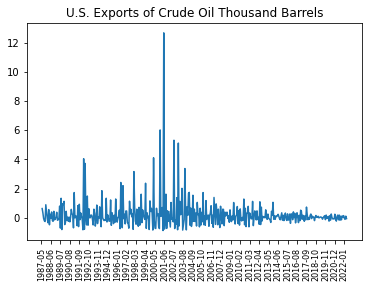

In [ ]:
plt.plot(df_oil['Date'], df_oil['U.S. Exports of Crude Oil Thousand Barrels'])
plt.xticks(np.arange(0, len(df_oil)+1, 13), rotation = 90, fontsize=8)
plt.title('U.S. Exports of Crude Oil Thousand Barrels')

# plt.savefig("exports_post.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# check data were there is an anomaly
df_3_anomaly = df_3.copy()
df_3_anomaly['Month'] = pd.to_datetime(df_3_anomaly['Month']).dt.strftime("%Y-%m")
df_3_anomaly = df_3_anomaly.sort_values(by='Month').reset_index(drop=True)
df_3_anomaly.iloc[970:980,:]

,Month,U.S. Exports of Crude Oil Thousand Barrels
970,2000-11,71
971,2000-12,498
972,2001-01,545
973,2001-02,674
974,2001-03,1147
975,2001-04,145
976,2001-05,1981
977,2001-06,452
978,2001-07,334
979,2001-08,874


### Macroeconomic data

In [ ]:
df_11 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/U.S._Inflation.csv")
df_11.iloc[:,1] = df_11.iloc[:,1]/100 # to make it in the same scale of others
df_11 = df_11.rename(columns={"CORESTICKM159SFRBATL_PCH": "Sticky Price Consumer Price Index"})
df_11.head()

,DATE,Sticky Price Consumer Price Index
0,1968-01-01,0.081717
1,1968-02-01,0.006018
2,1968-03-01,0.127554
3,1968-04-01,0.003314
4,1968-05-01,-0.016258


In [ ]:
df_12 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/U.S._Recession.csv")
df_12 = df_12.rename(columns={"USRECDM": "U.S. Recession"})
df_12.head()

,DATE,U.S. Recession
0,1854-12-01,0
1,1855-01-01,0
2,1855-02-01,0
3,1855-03-01,0
4,1855-04-01,0


In [ ]:
df_13 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/GDP_US.csv")
df_13.head()

,DATE,GDP_PCH
0,1947-04-01,1.15313
1,1947-07-01,1.47052
2,1947-10-01,4.07076
3,1948-01-01,2.30880
4,1948-04-01,2.56828


In [ ]:
df_14 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/GDP_UK.csv")
df_14.head()

,DATE,UKNGDP_PCH
0,1955-04-01,0.49314
1,1955-07-01,3.69106
2,1955-10-01,1.83128
3,1956-01-01,2.70762
4,1956-04-01,1.35747


In [ ]:
df_15 = pd.read_csv("/content/drive/MyDrive/ai for finance/Progetti/Finale/Data/GDP_FR.csv")
df_15.head()

,DATE,CPMNACSCAB1GQFR_PCH
0,1975-04-01,2.23470
1,1975-07-01,2.90184
2,1975-10-01,3.56934
3,1976-01-01,3.92920
4,1976-04-01,4.58557


In [ ]:
# merge macroeconomic data

# montly
dfs = [df_11, df_12]
df_macro_m = reduce(lambda left, right: pd.merge(left, right, on='DATE'), dfs)
display(df_macro_m.head())

# quarterly
dfs = [df_13, df_14, df_15]
df_macro_q = reduce(lambda left, right: pd.merge(left, right, on='DATE'), dfs)
display(df_macro_q.head())

,DATE,Sticky Price Consumer Price Index,U.S. Recession
0,1968-01-01,0.081717,0
1,1968-02-01,0.006018,0
2,1968-03-01,0.127554,0
3,1968-04-01,0.003314,0
4,1968-05-01,-0.016258,0


,DATE,GDP_PCH,UKNGDP_PCH,CPMNACSCAB1GQFR_PCH
0,1975-04-01,2.21129,4.90346,2.23470
1,1975-07-01,3.50921,4.01922,2.90184
2,1975-10-01,3.04190,5.58198,3.56934
3,1976-01-01,3.32926,5.04052,3.92920
4,1976-04-01,1.74926,2.68168,4.58557


In [ ]:
# change DATE column name to Date
# format date keeping just the year and month
df_macro_m = df_macro_m.rename(columns={"DATE": "Date"})
df_macro_m['Date'] = pd.to_datetime(df_macro_m['Date']).dt.strftime("%Y-%m")
display(df_macro_m.head())

df_macro_q = df_macro_q.rename(columns={"DATE": "Date"})
df_macro_q['Date'] = pd.to_datetime(df_macro_q['Date']).dt.strftime("%Y-%m")
display(df_macro_q.head())

,Date,Sticky Price Consumer Price Index,U.S. Recession
0,1968-01,0.081717,0
1,1968-02,0.006018,0
2,1968-03,0.127554,0
3,1968-04,0.003314,0
4,1968-05,-0.016258,0


,Date,GDP_PCH,UKNGDP_PCH,CPMNACSCAB1GQFR_PCH
0,1975-04,2.21129,4.90346,2.23470
1,1975-07,3.50921,4.01922,2.90184
2,1975-10,3.04190,5.58198,3.56934
3,1976-01,3.32926,5.04052,3.92920
4,1976-04,1.74926,2.68168,4.58557


### Combine datasets and add dummy variables

In [ ]:
dfs = [portfolio, df_oil, df_macro_m]
df = reduce(lambda left, right: pd.merge(left, right, on='Date'), dfs).dropna()
df.head()

,Date,XOM,SHEL.AS,TOT.TO,BP.L,CVX,MRO,.SP500,VLO,ENI.MI,...,U.S. Exports of Crude Oil Thousand Barrels,U.S. Imports of Crude Oil Thousand Barrels,U.S. Field Production of Crude Oil Thousand Barrels,U.S. Product Supplied of Crude Oil and Petroleum Products Thousand Barrels,Cushing OK Crude Oil Future Contract 1 Dollars per Barrel,Cushing OK Crude Oil Future Contract 2 Dollars per Barrel,Cushing OK Crude Oil Future Contract 3 Dollars per Barrel,Cushing OK Crude Oil Future Contract 4 Dollars per Barrel,Sticky Price Consumer Price Index,U.S. Recession
140,1999-01,-0.039316,-0.166833,0.000000,-0.084123,-0.101733,-0.244813,0.041009,-0.114706,-0.068456,...,0.192982,0.004944,-0.013253,-0.020106,0.104332,0.077320,0.057741,0.043336,-0.022660,0
141,1999-02,-0.052491,0.131542,-0.166667,0.081509,0.031879,-0.090659,-0.032283,-0.066445,0.019544,...,0.003001,-0.088705,-0.096449,-0.093073,-0.037630,-0.031898,-0.029272,-0.028213,-0.027994,0
142,1999-03,0.060094,0.231250,0.100000,0.179415,0.154472,0.329305,0.038794,0.416370,0.114452,...,-0.114303,0.142601,0.091766,0.129729,0.221298,0.214168,0.199674,0.185484,-0.033294,0
143,1999-04,0.177148,0.118782,0.090909,0.124464,0.123944,0.136364,0.037944,-0.103015,0.049241,...,2.365541,0.024970,-0.031509,-0.049383,0.178474,0.164858,0.156929,0.146259,-0.004719,0
144,1999-05,-0.038375,-0.031760,0.600000,-0.052587,-0.072682,-0.042000,-0.024970,-0.100840,-0.027483,...,-0.724754,0.015716,0.031175,0.009258,0.027168,0.029121,0.029947,0.032641,-0.032799,0


In [ ]:
# add dummy variables regarding covid and ukraine war
df['COVID-19'] = np.where(df['Date'] >= '2020-01', 1, 0)
df['Russia-Ukraine War'] = np.where(df['Date'] > '2022-02', 1, 0)
df.head()

,Date,XOM,SHEL.AS,TOT.TO,BP.L,CVX,MRO,.SP500,VLO,ENI.MI,...,U.S. Field Production of Crude Oil Thousand Barrels,U.S. Product Supplied of Crude Oil and Petroleum Products Thousand Barrels,Cushing OK Crude Oil Future Contract 1 Dollars per Barrel,Cushing OK Crude Oil Future Contract 2 Dollars per Barrel,Cushing OK Crude Oil Future Contract 3 Dollars per Barrel,Cushing OK Crude Oil Future Contract 4 Dollars per Barrel,Sticky Price Consumer Price Index,U.S. Recession,COVID-19,Russia-Ukraine War
140,1999-01,-0.039316,-0.166833,0.000000,-0.084123,-0.101733,-0.244813,0.041009,-0.114706,-0.068456,...,-0.013253,-0.020106,0.104332,0.077320,0.057741,0.043336,-0.022660,0,0,0
141,1999-02,-0.052491,0.131542,-0.166667,0.081509,0.031879,-0.090659,-0.032283,-0.066445,0.019544,...,-0.096449,-0.093073,-0.037630,-0.031898,-0.029272,-0.028213,-0.027994,0,0,0
142,1999-03,0.060094,0.231250,0.100000,0.179415,0.154472,0.329305,0.038794,0.416370,0.114452,...,0.091766,0.129729,0.221298,0.214168,0.199674,0.185484,-0.033294,0,0,0
143,1999-04,0.177148,0.118782,0.090909,0.124464,0.123944,0.136364,0.037944,-0.103015,0.049241,...,-0.031509,-0.049383,0.178474,0.164858,0.156929,0.146259,-0.004719,0,0,0
144,1999-05,-0.038375,-0.031760,0.600000,-0.052587,-0.072682,-0.042000,-0.024970,-0.100840,-0.027483,...,0.031175,0.009258,0.027168,0.029121,0.029947,0.032641,-0.032799,0,0,0


## Perform exploratory analysis

In [ ]:
n_var = len(df.columns) - 1
n_var

27

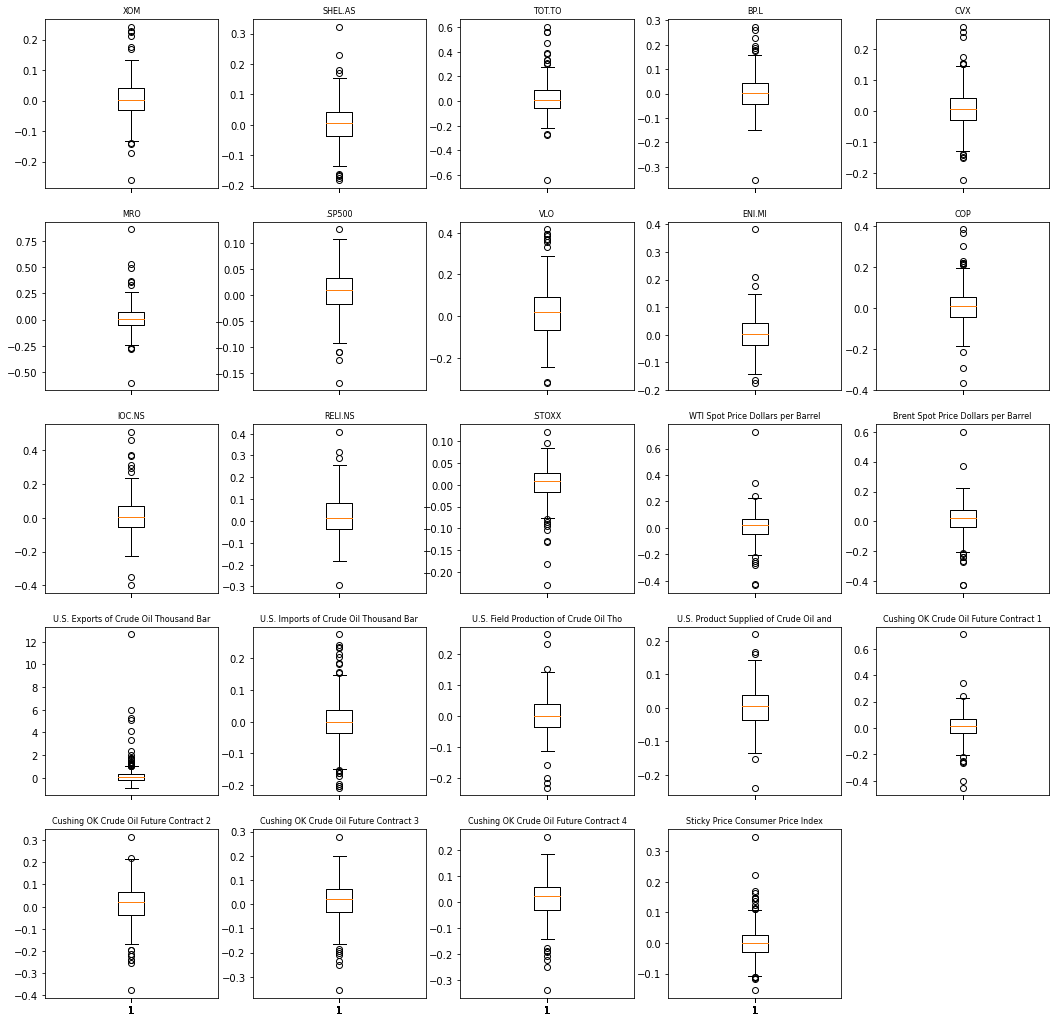

In [ ]:
# visualize distribution of each variable (except dummy variables)
rows, cols = 5, 5
fig, ax = plt.subplots(rows, cols, sharex=True, sharey=False, figsize=(18,18))
cols_name = df.columns[1:-3]

for i in range(rows):
    for j in range(cols):
        try:
            col_name = cols_name[i*rows+j]
            ax[i,j].boxplot(df[col_name])
            ax[i,j].set_title(col_name[:38], fontsize=8)
        except: 
            fig.delaxes(ax[i,j])

# plt.savefig("boxplots.jpg", dpi=300, bbox_inches='tight')
plt.show()

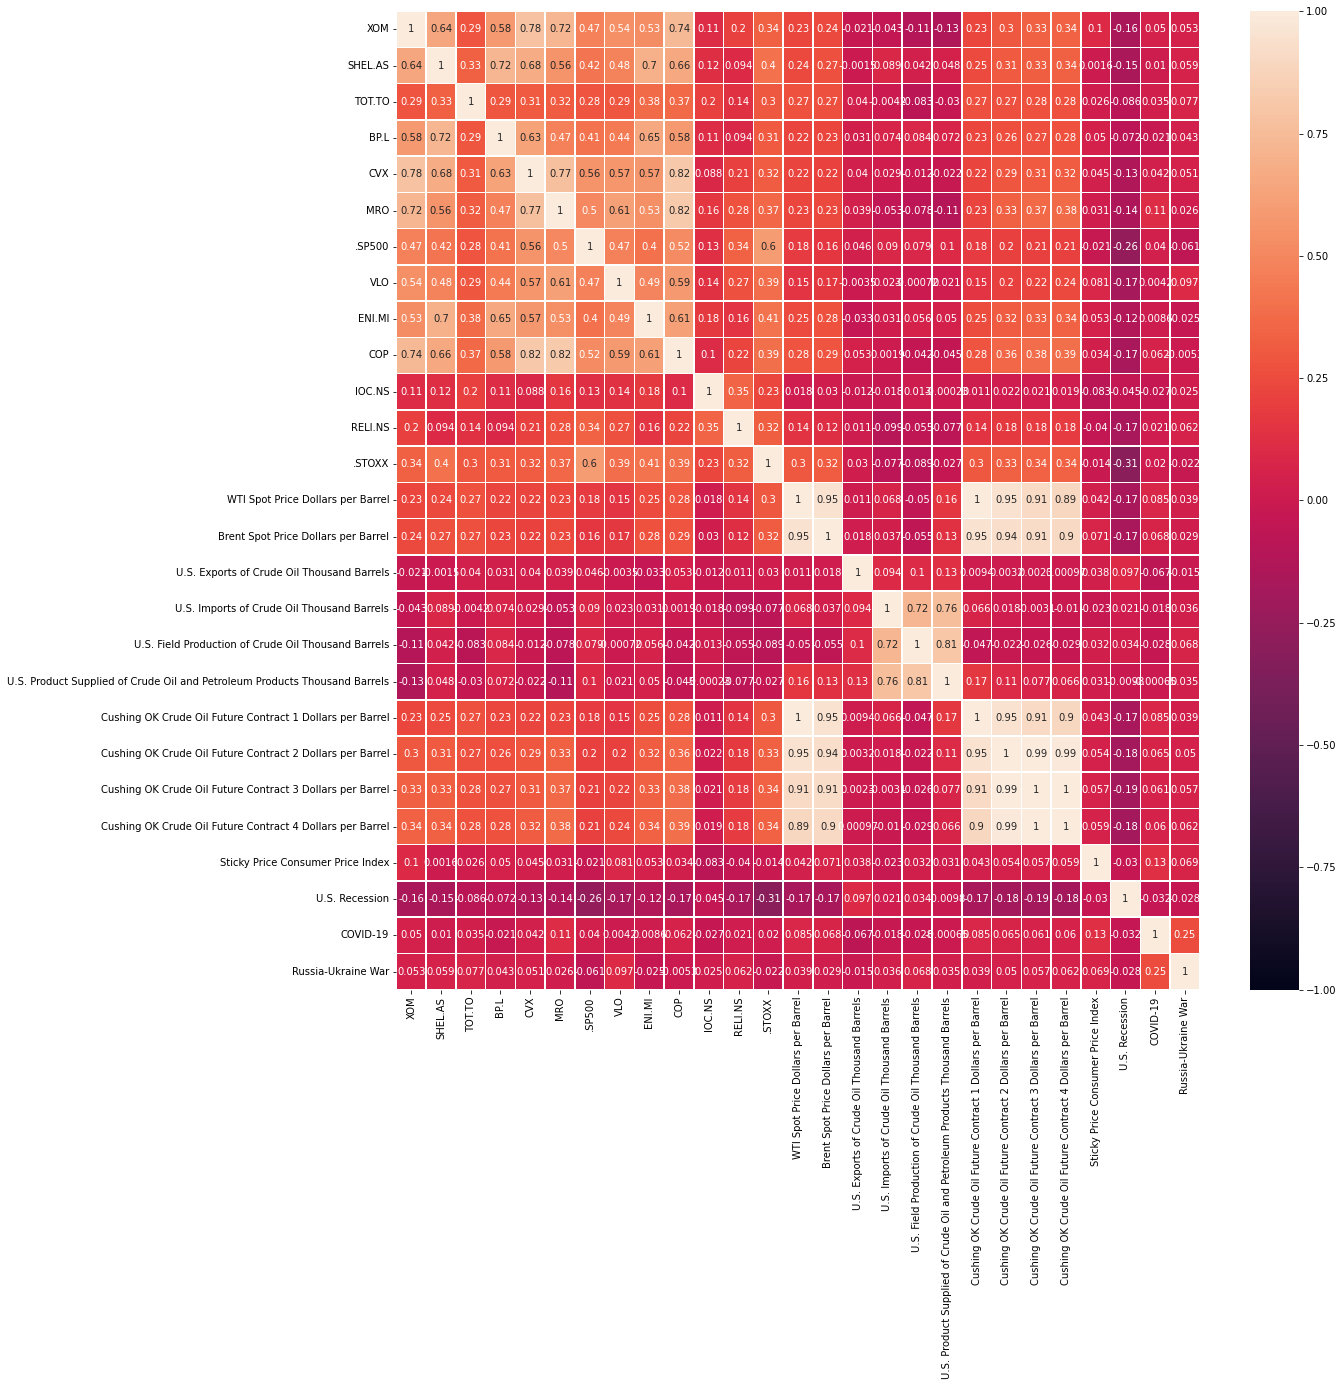

In [ ]:
# plot correlation among variables
fig, ax = plt.subplots(figsize=(18, 18)) 

sns.heatmap(df.iloc[:, 1:].corr(), annot=True, vmin=-1, linewidths=.5, ax=ax)
# plt.savefig("heatmap.jpg", dpi=300, bbox_inches='tight')
plt.show()

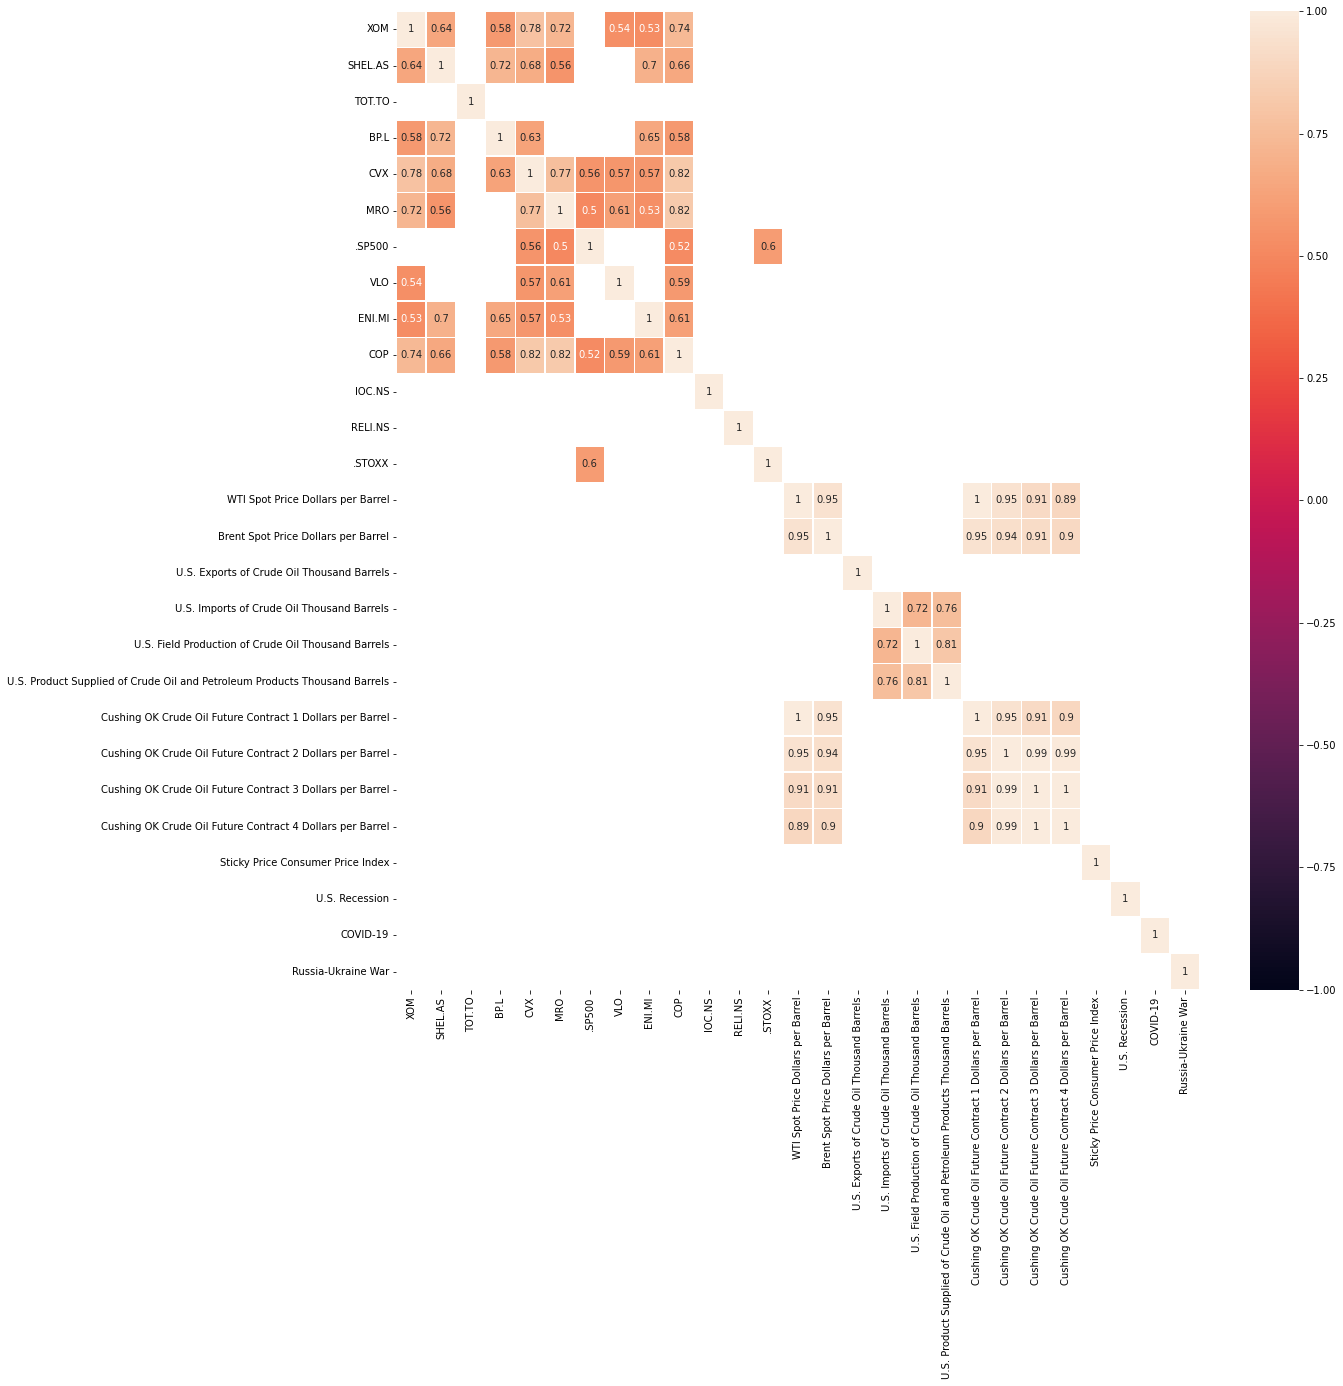

In [ ]:
# plot correlation higher than 0.5 among variables
fig, ax = plt.subplots(figsize=(18, 18)) 

sns.heatmap(df.iloc[:,1:].corr()[abs(df.iloc[:,1:].corr()) > 0.5], annot=True, vmin=-1, linewidths=.5, ax=ax)
# plt.savefig("heatmap5.jpg", dpi=300, bbox_inches='tight')
plt.show()

## Perform econometric analysis

In [ ]:
def mse(df_pred, df_true):
    return np.square(df_pred - df_true).mean()

In [ ]:
train_df = df.iloc[48:]
test_df = df.iloc[:48]

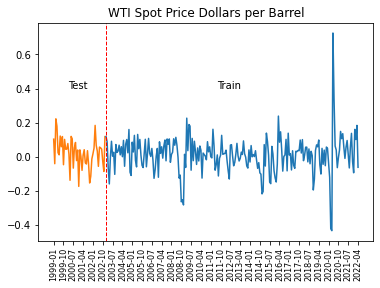

In [ ]:
# plot WTI prices of train an test sets
cmap = plt.get_cmap("tab10")
df_plot = df.set_index("Date")["WTI Spot Price Dollars per Barrel"]

plt.plot(df_plot[:48], c=cmap(1))
plt.plot(df_plot[48:], c=cmap(0))

plt.xticks(np.arange(0, len(df_plot)+1, 9), rotation = 90, fontsize=8)

# adding text inside the plot
plt.text(150, 0.4, 'Train', fontsize = 10)
plt.text(13, 0.4, 'Test', fontsize = 10)

plt.axvline(x=df_plot.index[48], c="r", ls='--', lw=1)

plt.title("WTI Spot Price Dollars per Barrel")

# plt.savefig("traintest.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
perfect_predictors = ["Cushing OK Crude Oil Future Contract 1 Dollars per Barrel", "Cushing OK Crude Oil Future Contract 2 Dollars per Barrel", "Cushing OK Crude Oil Future Contract 3 Dollars per Barrel"]

### GARCH models

In [ ]:
arch_effect = {}

for column in df.columns.difference(["Date"] + perfect_predictors):
  model = arch_model(df[column], rescale=False).fit()

  if model.pvalues["alpha[1]"] < 0.05:
    df[column+"_CondVol"] = model.conditional_volatility
    arch_effect[column] = model.pvalues["alpha[1]"]

In [ ]:
arch_effect

{'.SP500': 0.001193865095343955,
 'BP.L': 0.044751870280556175,
 'COP': 0.024933773538248424,
 'Cushing OK Crude Oil Future Contract 4 Dollars per Barrel': 0.02879032368820862,
 'MRO': 0.008782732165943843,
 'SHEL.AS': 0.036904447425088305,
 'Sticky Price Consumer Price Index': 0.027062079254154058,
 'U.S. Product Supplied of Crude Oil and Petroleum Products Thousand Barrels': 0.0003468934170807718,
 'U.S. Recession': 1.978766430078825e-19,
 'WTI Spot Price Dollars per Barrel': 0.0029354002552216337,
 'XOM': 0.03160961690044632}

In [ ]:
# re-split into train and test sets after having added conditional volatilities
train_df = df.iloc[48:]
test_df = df.iloc[:48]

### Non-perfect multicollinearity predictors

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
nonperfect_predictors = "+".join('Q("' + df.columns.difference(["Date", "WTI Spot Price Dollars per Barrel"] + perfect_predictors) + '")')
nonperfect_formula = 'Q("WTI Spot Price Dollars per Barrel") ~' + nonperfect_predictors

### Fit multiple static linear regression with different lags (from 1 to 12)

In [ ]:
static_nonperfect_formula = nonperfect_formula.replace('+Q("WTI Spot Price Dollars per Barrel_CondVol")', '')
tilde_pos = static_nonperfect_formula.find('~')
nonperfect_formula_lagged = static_nonperfect_formula[:tilde_pos]

for c in static_nonperfect_formula[tilde_pos:]:
    nonperfect_formula_lagged += c
    if c == ')':
        nonperfect_formula_lagged += ".shift(i)"

In [ ]:
test_error = {}

robust = defaultdict(int)

for i in range(1,13):
    lm = sm.OLS.from_formula(nonperfect_formula_lagged, data=train_df).fit()
    test_error[str(i)] = mse(lm.predict(test_df), test_df['WTI Spot Price Dollars per Barrel'])

    shift_name = nonperfect_formula_lagged.replace('(i', '('+str(i))[tilde_pos+1:].split('+')
    lm.summary(xname=['Intercept'] + shift_name)

    for v, p in enumerate(lm.pvalues):
      if p <= 0.05:
        name = lm.params.index[v]
        name = name[:name.find(')')+1]
        robust[name] += 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.475
Model:                                                OLS   Adj. R-squared:                  0.387
Method:                                     Least Squares   F-statistic:                     5.393
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):           1.78e-14
Time:                                            19:19:10   Log-Likelihood:                 262.28
No. Observations:                                     231   AIC:                            -456.6
Df Residuals:                                         197   BIC:                            -339.5
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.1214      0.078     -1.554      0.122      -0.276       0.033
Q(".SP500").shift(1)                                                                                -0.1874      0.234     -0.800      0.425      -0.650       0.275
Q(".SP500_CondVol").shift(1)                                                                         0.0378      0.578      0.065      0.948      -1.102       1.178
Q(".STOXX").shift(1)                                                                                 0.0241      0.216      0.112      0.911      -0.401       0.449
Q("BP.L").shift(1)                                                                                  -0.0291      0.125     -0.233      0.816      -0.276       0.218
Q("BP.L_CondVol").shift(1)                                                                           0.3795      0.402      0.945      0.346      -0.413       1.172
Q("Brent Spot Price Dollars per Barrel").shift(1)                                                    0.2026      0.157      1.292      0.198      -0.107       0.512
Q("COP").shift(1)                                                                                    0.0389      0.153      0.255      0.799      -0.262       0.340
Q("COP_CondVol").shift(1)                                                                           -0.2141      0.573     -0.374      0.709      -1.344       0.916
Q("COVID-19").shift(1)                                                                              -0.0576      0.047     -1.239      0.217      -0.149       0.034
Q("CVX").shift(1)                                                                                    0.0656      0.202      0.326      0.745      -0.332       0.463
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(1)                             -0.1962      0.203     -0.968      0.334      -0.596       0.204
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(1)                      0.7282      0.462      1.575      0.117      -0.184       1.640
Q("ENI.MI").shift(1)                                                                                 0.0456      0.152      0.301      0.764      -0.254       0.345
Q("IOC.NS").shift(1)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.168
Model:                                                OLS   Adj. R-squared:                  0.032
Method:                                     Least Squares   F-statistic:                     1.239
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.190
Time:                                            19:19:11   Log-Likelihood:                 207.98
No. Observations:                                     230   AIC:                            -350.0
Df Residuals:                                         197   BIC:                            -236.5
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.1928      0.098     -1.962      0.051      -0.387       0.001
Q(".SP500").shift(2)                                                                                 0.1578      0.295      0.535      0.593      -0.423       0.739
Q(".SP500_CondVol").shift(2)                                                                        -0.3972      0.727     -0.546      0.585      -1.831       1.036
Q(".STOXX").shift(2)                                                                                -0.3570      0.271     -1.318      0.189      -0.891       0.177
Q("BP.L").shift(2)                                                                                  -0.1192      0.157     -0.758      0.449      -0.429       0.191
Q("BP.L_CondVol").shift(2)                                                                           0.5017      0.505      0.993      0.322      -0.494       1.498
Q("Brent Spot Price Dollars per Barrel").shift(2)                                                    0.0066      0.197      0.033      0.974      -0.382       0.395
Q("COP").shift(2)                                                                                    0.0169      0.192      0.088      0.930      -0.362       0.395
Q("COP_CondVol").shift(2)                                                                            0.5083      0.720      0.706      0.481      -0.912       1.929
Q("COVID-19").shift(2)                                                                              -0.0399      0.058     -0.682      0.496      -0.155       0.075
Q("CVX").shift(2)                                                                                    0.0552      0.253      0.218      0.828      -0.445       0.555
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(2)                              0.0071      0.255      0.028      0.978      -0.496       0.510
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(2)                      0.4588      0.581      0.789      0.431      -0.688       1.605
Q("ENI.MI").shift(2)                                                                                 0.1118      0.191      0.586      0.559      -0.264       0.488
Q("IOC.NS").shift(2)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.242
Model:                                                OLS   Adj. R-squared:                  0.118
Method:                                     Least Squares   F-statistic:                     1.951
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):            0.00311
Time:                                            19:19:11   Log-Likelihood:                 217.49
No. Observations:                                     229   AIC:                            -369.0
Df Residuals:                                         196   BIC:                            -255.7
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.0014      0.095     -0.015      0.988      -0.188       0.185
Q(".SP500").shift(3)                                                                                -0.0886      0.282     -0.314      0.754      -0.645       0.467
Q(".SP500_CondVol").shift(3)                                                                         0.0186      0.695      0.027      0.979      -1.352       1.389
Q(".STOXX").shift(3)                                                                                -0.3516      0.260     -1.354      0.177      -0.864       0.160
Q("BP.L").shift(3)                                                                                  -0.0710      0.151     -0.469      0.639      -0.369       0.227
Q("BP.L_CondVol").shift(3)                                                                           0.4361      0.484      0.901      0.369      -0.518       1.391
Q("Brent Spot Price Dollars per Barrel").shift(3)                                                   -0.1146      0.189     -0.606      0.545      -0.488       0.258
Q("COP").shift(3)                                                                                   -0.3459      0.184     -1.881      0.061      -0.709       0.017
Q("COP_CondVol").shift(3)                                                                            1.1146      0.689      1.617      0.107      -0.245       2.474
Q("COVID-19").shift(3)                                                                               0.0675      0.056      1.203      0.230      -0.043       0.178
Q("CVX").shift(3)                                                                                    0.5573      0.245      2.271      0.024       0.073       1.041
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(3)                              0.0492      0.244      0.202      0.840      -0.432       0.530
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(3)                      0.1556      0.559      0.278      0.781      -0.948       1.259
Q("ENI.MI").shift(3)                                                                                 0.1402      0.183      0.767      0.444      -0.220       0.501
Q("IOC.NS").shift(3)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.299
Model:                                                OLS   Adj. R-squared:                  0.184
Method:                                     Least Squares   F-statistic:                     2.603
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):           3.09e-05
Time:                                            19:19:11   Log-Likelihood:                 226.32
No. Observations:                                     228   AIC:                            -386.6
Df Residuals:                                         195   BIC:                            -273.5
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            0.3845      0.091      4.221      0.000       0.205       0.564
Q(".SP500").shift(4)                                                                                -1.1640      0.275     -4.230      0.000      -1.707      -0.621
Q(".SP500_CondVol").shift(4)                                                                         1.5149      0.667      2.271      0.024       0.199       2.830
Q(".STOXX").shift(4)                                                                                 0.4550      0.249      1.828      0.069      -0.036       0.946
Q("BP.L").shift(4)                                                                                   0.1331      0.145      0.918      0.360      -0.153       0.419
Q("BP.L_CondVol").shift(4)                                                                           0.1857      0.464      0.400      0.689      -0.729       1.101
Q("Brent Spot Price Dollars per Barrel").shift(4)                                                   -0.3072      0.182     -1.691      0.093      -0.666       0.051
Q("COP").shift(4)                                                                                   -0.1951      0.177     -1.103      0.272      -0.544       0.154
Q("COP_CondVol").shift(4)                                                                            1.1033      0.661      1.670      0.097      -0.200       2.406
Q("COVID-19").shift(4)                                                                               0.3225      0.055      5.840      0.000       0.214       0.431
Q("CVX").shift(4)                                                                                    0.2015      0.236      0.854      0.394      -0.264       0.667
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(4)                              0.3050      0.234      1.305      0.194      -0.156       0.766
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(4)                     -0.3014      0.537     -0.561      0.575      -1.360       0.758
Q("ENI.MI").shift(4)                                                                                 0.0114      0.175      0.065      0.948      -0.335       0.357
Q("IOC.NS").shift(4)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.140
Model:                                                OLS   Adj. R-squared:                 -0.002
Method:                                     Least Squares   F-statistic:                    0.9848
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.497
Time:                                            19:19:11   Log-Likelihood:                 201.55
No. Observations:                                     227   AIC:                            -337.1
Df Residuals:                                         194   BIC:                            -224.1
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            0.2451      0.101      2.419      0.016       0.045       0.445
Q(".SP500").shift(5)                                                                                -0.2924      0.306     -0.954      0.341      -0.897       0.312
Q(".SP500_CondVol").shift(5)                                                                         1.1368      0.741      1.534      0.127      -0.325       2.598
Q(".STOXX").shift(5)                                                                                 0.0509      0.277      0.184      0.855      -0.496       0.597
Q("BP.L").shift(5)                                                                                   0.2518      0.161      1.562      0.120      -0.066       0.570
Q("BP.L_CondVol").shift(5)                                                                          -0.1736      0.515     -0.337      0.737      -1.190       0.843
Q("Brent Spot Price Dollars per Barrel").shift(5)                                                    0.0701      0.202      0.347      0.729      -0.328       0.468
Q("COP").shift(5)                                                                                   -0.1634      0.197     -0.830      0.407      -0.551       0.225
Q("COP_CondVol").shift(5)                                                                            1.2326      0.734      1.679      0.095      -0.216       2.681
Q("COVID-19").shift(5)                                                                               0.1494      0.062      2.406      0.017       0.027       0.272
Q("CVX").shift(5)                                                                                    0.0774      0.262      0.296      0.768      -0.439       0.594
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(5)                             -0.0324      0.260     -0.125      0.901      -0.545       0.480
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(5)                     -0.4666      0.597     -0.782      0.435      -1.644       0.710
Q("ENI.MI").shift(5)                                                                                -0.1910      0.195     -0.980      0.329      -0.576       0.194
Q("IOC.NS").shift(5)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.125
Model:                                                OLS   Adj. R-squared:                 -0.021
Method:                                     Least Squares   F-statistic:                    0.8583
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.688
Time:                                            19:19:11   Log-Likelihood:                 198.46
No. Observations:                                     226   AIC:                            -330.9
Df Residuals:                                         193   BIC:                            -218.0
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            0.0263      0.102      0.257      0.798      -0.176       0.228
Q(".SP500").shift(6)                                                                                -0.0607      0.310     -0.196      0.845      -0.672       0.551
Q(".SP500_CondVol").shift(6)                                                                         0.5247      0.749      0.701      0.484      -0.952       2.001
Q(".STOXX").shift(6)                                                                                 0.0386      0.283      0.136      0.892      -0.520       0.597
Q("BP.L").shift(6)                                                                                   0.1347      0.163      0.827      0.409      -0.187       0.456
Q("BP.L_CondVol").shift(6)                                                                          -0.4512      0.521     -0.867      0.387      -1.478       0.576
Q("Brent Spot Price Dollars per Barrel").shift(6)                                                    0.0775      0.204      0.380      0.704      -0.325       0.480
Q("COP").shift(6)                                                                                    0.0464      0.199      0.233      0.816      -0.347       0.440
Q("COP_CondVol").shift(6)                                                                            1.3316      0.742      1.795      0.074      -0.132       2.795
Q("COVID-19").shift(6)                                                                               0.0450      0.063      0.711      0.478      -0.080       0.170
Q("CVX").shift(6)                                                                                   -0.0370      0.267     -0.138      0.890      -0.564       0.491
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(6)                             -0.1585      0.263     -0.604      0.547      -0.676       0.359
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(6)                     -0.0251      0.604     -0.041      0.967      -1.217       1.167
Q("ENI.MI").shift(6)                                                                                 0.2532      0.197      1.285      0.200      -0.135       0.642
Q("IOC.NS").shift(6)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.124
Model:                                                OLS   Adj. R-squared:                 -0.022
Method:                                     Least Squares   F-statistic:                    0.8484
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.702
Time:                                            19:19:11   Log-Likelihood:                 197.00
No. Observations:                                     225   AIC:                            -328.0
Df Residuals:                                         192   BIC:                            -215.3
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.0437      0.103     -0.426      0.671      -0.246       0.159
Q(".SP500").shift(7)                                                                                 0.0112      0.312      0.036      0.971      -0.604       0.626
Q(".SP500_CondVol").shift(7)                                                                        -1.0853      0.755     -1.438      0.152      -2.574       0.403
Q(".STOXX").shift(7)                                                                                 0.1645      0.284      0.578      0.564      -0.396       0.725
Q("BP.L").shift(7)                                                                                  -0.1214      0.164     -0.742      0.459      -0.444       0.201
Q("BP.L_CondVol").shift(7)                                                                          -0.4152      0.523     -0.795      0.428      -1.446       0.615
Q("Brent Spot Price Dollars per Barrel").shift(7)                                                    0.2062      0.206      1.000      0.318      -0.200       0.613
Q("COP").shift(7)                                                                                   -0.1590      0.201     -0.790      0.431      -0.556       0.238
Q("COP_CondVol").shift(7)                                                                            1.7896      0.747      2.396      0.018       0.317       3.263
Q("COVID-19").shift(7)                                                                               0.0361      0.065      0.557      0.578      -0.092       0.164
Q("CVX").shift(7)                                                                                    0.3409      0.271      1.258      0.210      -0.193       0.875
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(7)                             -0.2979      0.264     -1.129      0.260      -0.818       0.222
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(7)                      0.6565      0.608      1.080      0.281      -0.542       1.855
Q("ENI.MI").shift(7)                                                                                -0.0187      0.198     -0.095      0.925      -0.409       0.371
Q("IOC.NS").shift(7)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.163
Model:                                                OLS   Adj. R-squared:                  0.023
Method:                                     Least Squares   F-statistic:                     1.162
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.265
Time:                                            19:19:11   Log-Likelihood:                 200.74
No. Observations:                                     224   AIC:                            -335.5
Df Residuals:                                         191   BIC:                            -222.9
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.1110      0.101     -1.101      0.272      -0.310       0.088
Q(".SP500").shift(8)                                                                                 0.4080      0.310      1.317      0.189      -0.203       1.019
Q(".SP500_CondVol").shift(8)                                                                        -1.0244      0.740     -1.385      0.168      -2.484       0.435
Q(".STOXX").shift(8)                                                                                -0.5180      0.279     -1.855      0.065      -1.069       0.033
Q("BP.L").shift(8)                                                                                  -0.0868      0.161     -0.538      0.591      -0.405       0.232
Q("BP.L_CondVol").shift(8)                                                                          -0.2316      0.513     -0.452      0.652      -1.243       0.780
Q("Brent Spot Price Dollars per Barrel").shift(8)                                                    0.3423      0.202      1.693      0.092      -0.057       0.741
Q("COP").shift(8)                                                                                    0.0436      0.202      0.216      0.829      -0.354       0.441
Q("COP_CondVol").shift(8)                                                                            0.3206      0.732      0.438      0.662      -1.123       1.764
Q("COVID-19").shift(8)                                                                              -0.0401      0.064     -0.623      0.534      -0.167       0.087
Q("CVX").shift(8)                                                                                   -0.5490      0.268     -2.049      0.042      -1.077      -0.021
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(8)                             -0.4807      0.259     -1.858      0.065      -0.991       0.030
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(8)                      0.6969      0.596      1.169      0.244      -0.479       1.873
Q("ENI.MI").shift(8)                                                                                -0.2008      0.194     -1.036      0.301      -0.583       0.181
Q("IOC.NS").shift(8)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.122
Model:                                                OLS   Adj. R-squared:                 -0.026
Method:                                     Least Squares   F-statistic:                    0.8217
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.740
Time:                                            19:19:11   Log-Likelihood:                 194.53
No. Observations:                                     223   AIC:                            -323.1
Df Residuals:                                         190   BIC:                            -210.6
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.1270      0.103     -1.229      0.220      -0.331       0.077
Q(".SP500").shift(9)                                                                                -0.2599      0.317     -0.819      0.414      -0.886       0.366
Q(".SP500_CondVol").shift(9)                                                                        -0.6453      0.761     -0.848      0.398      -2.147       0.856
Q(".STOXX").shift(9)                                                                                 0.2481      0.286      0.867      0.387      -0.316       0.813
Q("BP.L").shift(9)                                                                                  -0.0744      0.166     -0.448      0.655      -0.402       0.253
Q("BP.L_CondVol").shift(9)                                                                          -0.3625      0.526     -0.690      0.491      -1.399       0.674
Q("Brent Spot Price Dollars per Barrel").shift(9)                                                   -0.1482      0.207     -0.715      0.475      -0.557       0.261
Q("COP").shift(9)                                                                                    0.2201      0.207      1.066      0.288      -0.187       0.628
Q("COP_CondVol").shift(9)                                                                            0.5975      0.750      0.797      0.427      -0.882       2.077
Q("COVID-19").shift(9)                                                                              -0.0413      0.066     -0.624      0.534      -0.172       0.089
Q("CVX").shift(9)                                                                                   -0.1589      0.275     -0.578      0.564      -0.701       0.384
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(9)                             -0.0253      0.265     -0.095      0.924      -0.548       0.498
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(9)                     -0.0149      0.611     -0.024      0.981      -1.220       1.190
Q("ENI.MI").shift(9)                                                                                 0.0276      0.199      0.138      0.890      -0.365       0.420
Q("IOC.NS").shift(9)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.113
Model:                                                OLS   Adj. R-squared:                 -0.037
Method:                                     Least Squares   F-statistic:                    0.7561
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.825
Time:                                            19:19:12   Log-Likelihood:                 192.30
No. Observations:                                     222   AIC:                            -318.6
Df Residuals:                                         189   BIC:                            -206.3
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            -0.0397      0.104     -0.381      0.703      -0.245       0.166
Q(".SP500").shift(10)                                                                                 0.1359      0.322      0.423      0.673      -0.498       0.770
Q(".SP500_CondVol").shift(10)                                                                         0.6848      0.776      0.882      0.379      -0.846       2.216
Q(".STOXX").shift(10)                                                                                 0.0896      0.288      0.311      0.756      -0.479       0.658
Q("BP.L").shift(10)                                                                                  -0.1490      0.167     -0.890      0.375      -0.479       0.181
Q("BP.L_CondVol").shift(10)                                                                          -0.5233      0.532     -0.983      0.327      -1.573       0.527
Q("Brent Spot Price Dollars per Barrel").shift(10)                                                   -0.2520      0.209     -1.205      0.230      -0.664       0.161
Q("COP").shift(10)                                                                                   -0.0110      0.208     -0.053      0.958      -0.422       0.400
Q("COP_CondVol").shift(10)                                                                           -0.2045      0.755     -0.271      0.787      -1.694       1.285
Q("COVID-19").shift(10)                                                                               0.0074      0.067      0.111      0.912      -0.124       0.139
Q("CVX").shift(10)                                                                                    0.1541      0.278      0.553      0.581      -0.395       0.703
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(10)                              0.2536      0.267      0.950      0.343      -0.273       0.780
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(10)                     -0.0608      0.616     -0.099      0.921      -1.275       1.154
Q("ENI.MI").shift(10)                                                                                 0.2256      0.200      1.127      0.261      -0.169       0.621
Q("IOC.NS").shift(10)                    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.141
Model:                                                OLS   Adj. R-squared:                 -0.006
Method:                                     Least Squares   F-statistic:                    0.9614
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.532
Time:                                            19:19:12   Log-Likelihood:                 194.38
No. Observations:                                     221   AIC:                            -322.8
Df Residuals:                                         188   BIC:                            -210.6
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                             0.0157      0.103      0.153      0.879      -0.187       0.218
Q(".SP500").shift(11)                                                                                -0.2591      0.317     -0.816      0.415      -0.885       0.367
Q(".SP500_CondVol").shift(11)                                                                         1.0581      0.774      1.367      0.173      -0.469       2.585
Q(".STOXX").shift(11)                                                                                -0.0554      0.284     -0.195      0.846      -0.616       0.506
Q("BP.L").shift(11)                                                                                  -0.1193      0.166     -0.721      0.472      -0.446       0.207
Q("BP.L_CondVol").shift(11)                                                                          -0.5827      0.528     -1.105      0.271      -1.623       0.458
Q("Brent Spot Price Dollars per Barrel").shift(11)                                                   -0.2223      0.208     -1.070      0.286      -0.632       0.188
Q("COP").shift(11)                                                                                   -0.0275      0.206     -0.133      0.894      -0.434       0.379
Q("COP_CondVol").shift(11)                                                                           -0.8585      0.746     -1.151      0.251      -2.330       0.613
Q("COVID-19").shift(11)                                                                               0.0293      0.066      0.445      0.657      -0.101       0.159
Q("CVX").shift(11)                                                                                    0.2524      0.278      0.908      0.365      -0.296       0.801
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(11)                              0.0566      0.265      0.214      0.831      -0.466       0.579
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(11)                     -0.7870      0.608     -1.294      0.197      -1.987       0.413
Q("ENI.MI").shift(11)                                                                                 0.4973      0.198      2.513      0.013       0.107       0.888
Q("IOC.NS").shift(11)                    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.192
Model:                                                OLS   Adj. R-squared:                  0.054
Method:                                     Least Squares   F-statistic:                     1.388
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):             0.0934
Time:                                            19:19:12   Log-Likelihood:                 199.79
No. Observations:                                     220   AIC:                            -333.6
Df Residuals:                                         187   BIC:                            -221.6
Df Model:                                              32                                         
Covariance Type:                                nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            -0.0031      0.100     -0.031      0.975      -0.200       0.194
Q(".SP500").shift(12)                                                                                -0.4261      0.309     -1.379      0.169      -1.036       0.183
Q(".SP500_CondVol").shift(12)                                                                         0.2944      0.758      0.388      0.698      -1.201       1.790
Q(".STOXX").shift(12)                                                                                 0.3887      0.276      1.406      0.161      -0.157       0.934
Q("BP.L").shift(12)                                                                                  -0.0632      0.162     -0.390      0.697      -0.383       0.256
Q("BP.L_CondVol").shift(12)                                                                          -0.6193      0.518     -1.195      0.234      -1.642       0.403
Q("Brent Spot Price Dollars per Barrel").shift(12)                                                    0.2164      0.202      1.069      0.286      -0.183       0.616
Q("COP").shift(12)                                                                                    0.1929      0.202      0.953      0.342      -0.206       0.592
Q("COP_CondVol").shift(12)                                                                           -0.0417      0.726     -0.057      0.954      -1.474       1.390
Q("COVID-19").shift(12)                                                                               0.0204      0.064      0.318      0.751      -0.106       0.147
Q("CVX").shift(12)                                                                                    0.8254      0.271      3.045      0.003       0.291       1.360
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(12)                             -0.3322      0.258     -1.288      0.199      -0.841       0.177
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(12)                      0.0647      0.591      0.109      0.913      -1.102       1.231
Q("ENI.MI").shift(12)                                                                                -0.0531      0.192     -0.276      0.783      -0.433       0.326
Q("IOC.NS").shift(12)                    

In [ ]:
test_error

{'1': 0.01129940834344157,
 '2': 0.009306750684990208,
 '3': 0.018673980782762757,
 '4': 0.024357802925639792,
 '5': 0.015505691008196935,
 '6': 0.012238690313460738,
 '7': 0.008340421805867578,
 '8': 0.012771687596923842,
 '9': 0.010023337007947693,
 '10': 0.008945628735054624,
 '11': 0.009688881594422855,
 '12': 0.012120793298671353}

In [ ]:
test_error_df = pd.DataFrame.from_dict(test_error, "index").reset_index()
test_error_df.rename(columns={"index": "Lags", 0: "MSE",}).set_index("Lags").T # .to_latex()

Lags,1,2,3,4,5,6,7,8,9,10,11,12
MSE,0.011299,0.009307,0.018674,0.024358,0.015506,0.012239,0.00834,0.012772,0.010023,0.008946,0.009689,0.012121


In [ ]:
robust

defaultdict(int,
            {'Q("MRO")': 1,
             'Q("RELI.NS")': 1,
             'Q("TOT.TO")': 1,
             'Q("U.S. Recession")': 3,
             'Q("U.S. Recession_CondVol")': 3,
             'Q("U.S. Product Supplied of Crude Oil and Petroleum Products Thousand Barrels")': 1,
             'Q("CVX")': 3,
             'Q("Sticky Price Consumer Price Index")': 1,
             '': 2,
             'Q(".SP500")': 1,
             'Q(".SP500_CondVol")': 1,
             'Q("COVID-19")': 2,
             'Q("SHEL.AS_CondVol")': 1,
             'Q("XOM_CondVol")': 1,
             'Q("SHEL.AS")': 1,
             'Q("COP_CondVol")': 1,
             'Q("MRO_CondVol")': 1,
             'Q("ENI.MI")': 1,
             'Q("IOC.NS")': 1,
             'Q("XOM")': 1})

### Fit multiple dynamic linear regression with different lags (from 1 to 12)

In [ ]:
nonperfect_formula_dyn_lagged = nonperfect_formula_lagged[:tilde_pos+1] + nonperfect_formula_lagged[:tilde_pos-1] + ".shift(i)+" + nonperfect_formula_lagged[tilde_pos+1:]

In [ ]:
test_error = {}

# robust = defaultdict(int)

for i in range(1,13):
    lm = sm.OLS.from_formula(nonperfect_formula_dyn_lagged, data=train_df).fit()
    test_error[str(i)] = mse(lm.predict(test_df), test_df['WTI Spot Price Dollars per Barrel'])

    shift_name = nonperfect_formula_dyn_lagged.replace('(i', '('+str(i))[tilde_pos+1:].split('+')
    lm.summary(xname=['Intercept'] + shift_name)

    for v, p in enumerate(lm.pvalues):
      if p <= 0.05:
        name = lm.params.index[v]
        name = name[:name.find(')')+1]
        robust[name] += 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.475
Model:                                                OLS   Adj. R-squared:                  0.384
Method:                                     Least Squares   F-statistic:                     5.217
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):           3.93e-14
Time:                                            19:19:12   Log-Likelihood:                 262.38
No. Observations:                                     231   AIC:                            -454.8
Df Residuals:                                         196   BIC:                            -334.3
Df Model:                                              34                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.1198      0.078     -1.528      0.128      -0.274       0.035
Q("WTI Spot Price Dollars per Barrel").shift(1)                                                      0.0859      0.211      0.408      0.684      -0.329       0.501
Q(".SP500").shift(1)                                                                                -0.1883      0.235     -0.802      0.424      -0.652       0.275
Q(".SP500_CondVol").shift(1)                                                                         0.0033      0.585      0.006      0.996      -1.151       1.158
Q(".STOXX").shift(1)                                                                                 0.0344      0.217      0.158      0.875      -0.394       0.463
Q("BP.L").shift(1)                                                                                  -0.0307      0.125     -0.245      0.807      -0.278       0.217
Q("BP.L_CondVol").shift(1)                                                                           0.3712      0.403      0.921      0.358      -0.424       1.166
Q("Brent Spot Price Dollars per Barrel").shift(1)                                                    0.1494      0.204      0.731      0.466      -0.254       0.552
Q("COP").shift(1)                                                                                    0.0356      0.153      0.233      0.816      -0.266       0.338
Q("COP_CondVol").shift(1)                                                                           -0.2142      0.574     -0.373      0.710      -1.346       0.918
Q("COVID-19").shift(1)                                                                              -0.0579      0.047     -1.242      0.216      -0.150       0.034
Q("CVX").shift(1)                                                                                    0.0600      0.202      0.296      0.767      -0.339       0.459
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(1)                             -0.2339      0.223     -1.048      0.296      -0.674       0.206
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(1)                      0.7587      0.469      1.616      0.108      -0.167       1.685
Q("ENI.MI").shift(1)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.170
Model:                                                OLS   Adj. R-squared:                  0.030
Method:                                     Least Squares   F-statistic:                     1.215
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.209
Time:                                            19:19:12   Log-Likelihood:                 208.29
No. Observations:                                     230   AIC:                            -348.6
Df Residuals:                                         196   BIC:                            -231.7
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.1964      0.099     -1.994      0.048      -0.391      -0.002
Q("WTI Spot Price Dollars per Barrel").shift(2)                                                     -0.1949      0.265     -0.737      0.462      -0.717       0.327
Q(".SP500").shift(2)                                                                                 0.1598      0.295      0.541      0.589      -0.422       0.742
Q(".SP500_CondVol").shift(2)                                                                        -0.3189      0.735     -0.434      0.665      -1.769       1.131
Q(".STOXX").shift(2)                                                                                -0.3804      0.273     -1.393      0.165      -0.919       0.158
Q("BP.L").shift(2)                                                                                  -0.1156      0.158     -0.734      0.464      -0.426       0.195
Q("BP.L_CondVol").shift(2)                                                                           0.5205      0.506      1.028      0.305      -0.478       1.519
Q("Brent Spot Price Dollars per Barrel").shift(2)                                                    0.1274      0.257      0.496      0.620      -0.379       0.634
Q("COP").shift(2)                                                                                    0.0243      0.192      0.127      0.899      -0.355       0.404
Q("COP_CondVol").shift(2)                                                                            0.5085      0.721      0.705      0.482      -0.914       1.931
Q("COVID-19").shift(2)                                                                              -0.0393      0.059     -0.672      0.503      -0.155       0.076
Q("CVX").shift(2)                                                                                    0.0681      0.254      0.268      0.789      -0.434       0.570
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(2)                              0.0926      0.280      0.330      0.742      -0.460       0.646
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(2)                      0.3895      0.590      0.660      0.510      -0.773       1.552
Q("ENI.MI").shift(2)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.253
Model:                                                OLS   Adj. R-squared:                  0.127
Method:                                     Least Squares   F-statistic:                     2.003
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):            0.00199
Time:                                            19:19:12   Log-Likelihood:                 219.25
No. Observations:                                     229   AIC:                            -370.5
Df Residuals:                                         195   BIC:                            -253.7
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.0091      0.094     -0.097      0.923      -0.195       0.177
Q("WTI Spot Price Dollars per Barrel").shift(3)                                                     -0.4369      0.251     -1.738      0.084      -0.933       0.059
Q(".SP500").shift(3)                                                                                -0.0838      0.280     -0.299      0.765      -0.637       0.469
Q(".SP500_CondVol").shift(3)                                                                         0.1946      0.699      0.278      0.781      -1.184       1.573
Q(".STOXX").shift(3)                                                                                -0.4035      0.260     -1.552      0.122      -0.916       0.109
Q("BP.L").shift(3)                                                                                  -0.0623      0.151     -0.414      0.680      -0.359       0.235
Q("BP.L_CondVol").shift(3)                                                                           0.4773      0.482      0.990      0.323      -0.474       1.428
Q("Brent Spot Price Dollars per Barrel").shift(3)                                                    0.1558      0.244      0.638      0.524      -0.326       0.637
Q("COP").shift(3)                                                                                   -0.3288      0.183     -1.795      0.074      -0.690       0.033
Q("COP_CondVol").shift(3)                                                                            1.1142      0.686      1.625      0.106      -0.238       2.466
Q("COVID-19").shift(3)                                                                               0.0687      0.056      1.230      0.220      -0.041       0.179
Q("CVX").shift(3)                                                                                    0.5853      0.245      2.391      0.018       0.103       1.068
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(3)                              0.2410      0.267      0.904      0.367      -0.285       0.767
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(3)                     -0.0013      0.564     -0.002      0.998      -1.113       1.111
Q("ENI.MI").shift(3)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.306
Model:                                                OLS   Adj. R-squared:                  0.188
Method:                                     Least Squares   F-statistic:                     2.593
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):           2.79e-05
Time:                                            19:19:12   Log-Likelihood:                 227.42
No. Observations:                                     228   AIC:                            -386.8
Df Residuals:                                         194   BIC:                            -270.2
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            0.3778      0.091      4.151      0.000       0.198       0.557
Q("WTI Spot Price Dollars per Barrel").shift(4)                                                     -0.3326      0.242     -1.374      0.171      -0.810       0.145
Q(".SP500").shift(4)                                                                                -1.1553      0.275     -4.207      0.000      -1.697      -0.614
Q(".SP500_CondVol").shift(4)                                                                         1.6456      0.672      2.448      0.015       0.320       2.972
Q(".STOXX").shift(4)                                                                                 0.4148      0.250      1.659      0.099      -0.078       0.908
Q("BP.L").shift(4)                                                                                   0.1392      0.145      0.962      0.337      -0.146       0.425
Q("BP.L_CondVol").shift(4)                                                                           0.2166      0.463      0.467      0.641      -0.697       1.131
Q("Brent Spot Price Dollars per Barrel").shift(4)                                                   -0.1025      0.235     -0.437      0.663      -0.565       0.360
Q("COP").shift(4)                                                                                   -0.1836      0.177     -1.039      0.300      -0.532       0.165
Q("COP_CondVol").shift(4)                                                                            1.1050      0.659      1.676      0.095      -0.195       2.405
Q("COVID-19").shift(4)                                                                               0.3222      0.055      5.848      0.000       0.214       0.431
Q("CVX").shift(4)                                                                                    0.2245      0.236      0.951      0.343      -0.241       0.690
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(4)                              0.4515      0.257      1.760      0.080      -0.054       0.957
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(4)                     -0.4237      0.543     -0.780      0.436      -1.495       0.647
Q("ENI.MI").shift(4)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.141
Model:                                                OLS   Adj. R-squared:                 -0.006
Method:                                     Least Squares   F-statistic:                    0.9596
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.536
Time:                                            19:19:13   Log-Likelihood:                 201.71
No. Observations:                                     227   AIC:                            -335.4
Df Residuals:                                         193   BIC:                            -219.0
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            0.2423      0.102      2.383      0.018       0.042       0.443
Q("WTI Spot Price Dollars per Barrel").shift(5)                                                     -0.1405      0.270     -0.520      0.604      -0.673       0.392
Q(".SP500").shift(5)                                                                                -0.2886      0.307     -0.940      0.348      -0.894       0.317
Q(".SP500_CondVol").shift(5)                                                                         1.1921      0.750      1.590      0.114      -0.287       2.671
Q(".STOXX").shift(5)                                                                                 0.0338      0.280      0.121      0.904      -0.518       0.585
Q("BP.L").shift(5)                                                                                   0.2543      0.162      1.574      0.117      -0.064       0.573
Q("BP.L_CondVol").shift(5)                                                                          -0.1606      0.517     -0.311      0.756      -1.180       0.859
Q("Brent Spot Price Dollars per Barrel").shift(5)                                                    0.1566      0.262      0.598      0.550      -0.360       0.673
Q("COP").shift(5)                                                                                   -0.1585      0.197     -0.803      0.423      -0.548       0.231
Q("COP_CondVol").shift(5)                                                                            1.2334      0.736      1.677      0.095      -0.218       2.684
Q("COVID-19").shift(5)                                                                               0.1493      0.062      2.400      0.017       0.027       0.272
Q("CVX").shift(5)                                                                                    0.0871      0.263      0.331      0.741      -0.432       0.606
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(5)                              0.0295      0.286      0.103      0.918      -0.535       0.594
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(5)                     -0.5182      0.606     -0.855      0.394      -1.714       0.677
Q("ENI.MI").shift(5)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.128
Model:                                                OLS   Adj. R-squared:                 -0.022
Method:                                     Least Squares   F-statistic:                    0.8507
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.702
Time:                                            19:19:13   Log-Likelihood:                 198.85
No. Observations:                                     226   AIC:                            -329.7
Df Residuals:                                         192   BIC:                            -213.4
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            0.0218      0.103      0.213      0.832      -0.181       0.224
Q("WTI Spot Price Dollars per Barrel").shift(6)                                                     -0.2207      0.273     -0.809      0.419      -0.758       0.317
Q(".SP500").shift(6)                                                                                -0.0545      0.310     -0.176      0.861      -0.667       0.558
Q(".SP500_CondVol").shift(6)                                                                         0.6116      0.757      0.808      0.420      -0.881       2.105
Q(".STOXX").shift(6)                                                                                 0.0111      0.285      0.039      0.969      -0.552       0.574
Q("BP.L").shift(6)                                                                                   0.1387      0.163      0.850      0.396      -0.183       0.460
Q("BP.L_CondVol").shift(6)                                                                          -0.4307      0.522     -0.826      0.410      -1.460       0.598
Q("Brent Spot Price Dollars per Barrel").shift(6)                                                    0.2132      0.264      0.807      0.421      -0.308       0.734
Q("COP").shift(6)                                                                                    0.0543      0.200      0.272      0.786      -0.340       0.448
Q("COP_CondVol").shift(6)                                                                            1.3325      0.743      1.794      0.074      -0.132       2.797
Q("COVID-19").shift(6)                                                                               0.0447      0.063      0.705      0.481      -0.080       0.170
Q("CVX").shift(6)                                                                                   -0.0224      0.268     -0.083      0.934      -0.552       0.507
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(6)                             -0.0613      0.289     -0.212      0.832      -0.631       0.509
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(6)                     -0.1068      0.613     -0.174      0.862      -1.316       1.103
Q("ENI.MI").shift(6)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.124
Model:                                                OLS   Adj. R-squared:                 -0.027
Method:                                     Least Squares   F-statistic:                    0.8218
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.744
Time:                                            19:19:13   Log-Likelihood:                 197.05
No. Observations:                                     225   AIC:                            -326.1
Df Residuals:                                         191   BIC:                            -210.0
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.0456      0.103     -0.442      0.659      -0.249       0.158
Q("WTI Spot Price Dollars per Barrel").shift(7)                                                     -0.0861      0.277     -0.311      0.756      -0.632       0.460
Q(".SP500").shift(7)                                                                                 0.0124      0.313      0.040      0.968      -0.604       0.629
Q(".SP500_CondVol").shift(7)                                                                        -1.0479      0.766     -1.368      0.173      -2.559       0.463
Q(".STOXX").shift(7)                                                                                 0.1545      0.287      0.539      0.591      -0.411       0.720
Q("BP.L").shift(7)                                                                                  -0.1194      0.164     -0.727      0.468      -0.443       0.204
Q("BP.L_CondVol").shift(7)                                                                          -0.4081      0.524     -0.778      0.437      -1.442       0.626
Q("Brent Spot Price Dollars per Barrel").shift(7)                                                    0.2580      0.265      0.972      0.332      -0.265       0.781
Q("COP").shift(7)                                                                                   -0.1549      0.202     -0.766      0.444      -0.554       0.244
Q("COP_CondVol").shift(7)                                                                            1.7871      0.749      2.387      0.018       0.311       3.264
Q("COVID-19").shift(7)                                                                               0.0354      0.065      0.545      0.587      -0.093       0.163
Q("CVX").shift(7)                                                                                    0.3449      0.272      1.269      0.206      -0.191       0.881
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(7)                             -0.2593      0.292     -0.888      0.376      -0.835       0.317
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(7)                      0.6227      0.619      1.007      0.315      -0.598       1.843
Q("ENI.MI").shift(7)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.163
Model:                                                OLS   Adj. R-squared:                  0.018
Method:                                     Least Squares   F-statistic:                     1.125
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.305
Time:                                            19:19:13   Log-Likelihood:                 200.81
No. Observations:                                     224   AIC:                            -333.6
Df Residuals:                                         190   BIC:                            -217.6
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.1130      0.101     -1.117      0.266      -0.313       0.087
Q("WTI Spot Price Dollars per Barrel").shift(8)                                                     -0.0884      0.272     -0.325      0.745      -0.624       0.447
Q(".SP500").shift(8)                                                                                 0.4101      0.311      1.321      0.188      -0.202       1.023
Q(".SP500_CondVol").shift(8)                                                                        -0.9862      0.751     -1.314      0.191      -2.467       0.495
Q(".STOXX").shift(8)                                                                                -0.5280      0.282     -1.875      0.062      -1.084       0.028
Q("BP.L").shift(8)                                                                                  -0.0851      0.162     -0.525      0.600      -0.404       0.234
Q("BP.L_CondVol").shift(8)                                                                          -0.2248      0.514     -0.437      0.663      -1.239       0.790
Q("Brent Spot Price Dollars per Barrel").shift(8)                                                    0.3956      0.261      1.518      0.131      -0.118       0.910
Q("COP").shift(8)                                                                                    0.0471      0.202      0.233      0.816      -0.352       0.446
Q("COP_CondVol").shift(8)                                                                            0.3182      0.734      0.434      0.665      -1.129       1.765
Q("COVID-19").shift(8)                                                                              -0.0410      0.065     -0.635      0.526      -0.168       0.086
Q("CVX").shift(8)                                                                                   -0.5443      0.269     -2.024      0.044      -1.075      -0.014
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(8)                             -0.4412      0.286     -1.541      0.125      -1.006       0.124
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(8)                      0.6617      0.607      1.090      0.277      -0.536       1.859
Q("ENI.MI").shift(8)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.137
Model:                                                OLS   Adj. R-squared:                 -0.014
Method:                                     Least Squares   F-statistic:                    0.9059
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.619
Time:                                            19:19:13   Log-Likelihood:                 196.45
No. Observations:                                     223   AIC:                            -324.9
Df Residuals:                                         189   BIC:                            -209.1
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
====================================================================================================================================================================
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           -0.1156      0.103     -1.124      0.262      -0.319       0.087
Q("WTI Spot Price Dollars per Barrel").shift(9)                                                      0.5002      0.276      1.812      0.072      -0.044       1.045
Q(".SP500").shift(9)                                                                                -0.2720      0.316     -0.862      0.390      -0.894       0.350
Q(".SP500_CondVol").shift(9)                                                                        -0.8621      0.766     -1.125      0.262      -2.373       0.649
Q(".STOXX").shift(9)                                                                                 0.3042      0.286      1.063      0.289      -0.260       0.869
Q("BP.L").shift(9)                                                                                  -0.0843      0.165     -0.510      0.611      -0.410       0.242
Q("BP.L_CondVol").shift(9)                                                                          -0.4010      0.523     -0.767      0.444      -1.432       0.630
Q("Brent Spot Price Dollars per Barrel").shift(9)                                                   -0.4498      0.265     -1.698      0.091      -0.972       0.073
Q("COP").shift(9)                                                                                    0.2005      0.206      0.975      0.331      -0.205       0.606
Q("COP_CondVol").shift(9)                                                                            0.6109      0.746      0.819      0.414      -0.860       2.082
Q("COVID-19").shift(9)                                                                              -0.0361      0.066     -0.548      0.584      -0.166       0.094
Q("CVX").shift(9)                                                                                   -0.1854      0.274     -0.677      0.499      -0.726       0.355
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(9)                             -0.2487      0.291     -0.855      0.394      -0.823       0.325
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(9)                      0.1843      0.617      0.299      0.766      -1.033       1.401
Q("ENI.MI").shift(9)                                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.114
Model:                                                OLS   Adj. R-squared:                 -0.042
Method:                                     Least Squares   F-statistic:                    0.7296
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.858
Time:                                            19:19:13   Log-Likelihood:                 192.30
No. Observations:                                     222   AIC:                            -316.6
Df Residuals:                                         188   BIC:                            -200.9
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            -0.0402      0.105     -0.385      0.701      -0.246       0.166
Q("WTI Spot Price Dollars per Barrel").shift(10)                                                     -0.0259      0.281     -0.092      0.927      -0.579       0.528
Q(".SP500").shift(10)                                                                                 0.1364      0.322      0.423      0.673      -0.500       0.773
Q(".SP500_CondVol").shift(10)                                                                         0.6966      0.789      0.883      0.378      -0.859       2.253
Q(".STOXX").shift(10)                                                                                 0.0867      0.291      0.298      0.766      -0.486       0.660
Q("BP.L").shift(10)                                                                                  -0.1485      0.168     -0.884      0.378      -0.480       0.183
Q("BP.L_CondVol").shift(10)                                                                          -0.5210      0.534     -0.975      0.331      -1.575       0.533
Q("Brent Spot Price Dollars per Barrel").shift(10)                                                   -0.2364      0.269     -0.879      0.380      -0.767       0.294
Q("COP").shift(10)                                                                                   -0.0099      0.209     -0.047      0.962      -0.423       0.403
Q("COP_CondVol").shift(10)                                                                           -0.2053      0.757     -0.271      0.787      -1.699       1.288
Q("COVID-19").shift(10)                                                                               0.0071      0.067      0.106      0.915      -0.125       0.139
Q("CVX").shift(10)                                                                                    0.1553      0.279      0.556      0.579      -0.396       0.707
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(10)                              0.2652      0.296      0.897      0.371      -0.318       0.849
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(10)                     -0.0713      0.628     -0.114      0.910      -1.310       1.167
Q("ENI.MI").shift(10)                    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.141
Model:                                                OLS   Adj. R-squared:                 -0.011
Method:                                     Least Squares   F-statistic:                    0.9273
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.586
Time:                                            19:19:14   Log-Likelihood:                 194.38
No. Observations:                                     221   AIC:                            -320.8
Df Residuals:                                         187   BIC:                            -205.2
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                             0.0156      0.103      0.151      0.880      -0.188       0.219
Q("WTI Spot Price Dollars per Barrel").shift(11)                                                     -0.0039      0.277     -0.014      0.989      -0.551       0.543
Q(".SP500").shift(11)                                                                                -0.2590      0.318     -0.814      0.417      -0.887       0.369
Q(".SP500_CondVol").shift(11)                                                                         1.0600      0.787      1.346      0.180      -0.493       2.613
Q(".STOXX").shift(11)                                                                                -0.0559      0.287     -0.195      0.846      -0.622       0.510
Q("BP.L").shift(11)                                                                                  -0.1193      0.166     -0.718      0.474      -0.447       0.208
Q("BP.L_CondVol").shift(11)                                                                          -0.5823      0.530     -1.099      0.273      -1.627       0.463
Q("Brent Spot Price Dollars per Barrel").shift(11)                                                   -0.2199      0.268     -0.822      0.412      -0.748       0.308
Q("COP").shift(11)                                                                                   -0.0273      0.207     -0.132      0.895      -0.435       0.380
Q("COP_CondVol").shift(11)                                                                           -0.8586      0.748     -1.148      0.252      -2.334       0.617
Q("COVID-19").shift(11)                                                                               0.0293      0.066      0.442      0.659      -0.101       0.160
Q("CVX").shift(11)                                                                                    0.2527      0.279      0.905      0.367      -0.298       0.803
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(11)                              0.0583      0.293      0.199      0.842      -0.519       0.636
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(11)                     -0.7886      0.620     -1.271      0.205      -2.012       0.435
Q("ENI.MI").shift(11)                    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.203
Model:                                                OLS   Adj. R-squared:                  0.061
Method:                                     Least Squares   F-statistic:                     1.435
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):             0.0713
Time:                                            19:19:14   Log-Likelihood:                 201.29
No. Observations:                                     220   AIC:                            -334.6
Df Residuals:                                         186   BIC:                            -219.2
Df Model:                                              33                                         
Covariance Type:                                nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            -0.0124      0.100     -0.125      0.901      -0.209       0.184
Q("WTI Spot Price Dollars per Barrel").shift(12)                                                     -0.4287      0.269     -1.596      0.112      -0.959       0.101
Q(".SP500").shift(12)                                                                                -0.4174      0.308     -1.357      0.177      -1.024       0.190
Q(".SP500_CondVol").shift(12)                                                                         0.5105      0.767      0.666      0.506      -1.002       2.023
Q(".STOXX").shift(12)                                                                                 0.3405      0.277      1.229      0.220      -0.206       0.887
Q("BP.L").shift(12)                                                                                  -0.0571      0.161     -0.353      0.724      -0.375       0.261
Q("BP.L_CondVol").shift(12)                                                                          -0.5687      0.517     -1.100      0.273      -1.589       0.452
Q("Brent Spot Price Dollars per Barrel").shift(12)                                                    0.4773      0.259      1.839      0.067      -0.035       0.989
Q("COP").shift(12)                                                                                    0.2063      0.202      1.022      0.308      -0.192       0.604
Q("COP_CondVol").shift(12)                                                                           -0.0608      0.723     -0.084      0.933      -1.487       1.365
Q("COVID-19").shift(12)                                                                               0.0152      0.064      0.239      0.812      -0.111       0.141
Q("CVX").shift(12)                                                                                    0.8519      0.270      3.150      0.002       0.318       1.385
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel").shift(12)                             -0.1439      0.283     -0.509      0.611      -0.702       0.414
Q("Cushing OK Crude Oil Future Contract 4 Dollars per Barrel_CondVol").shift(12)                     -0.1097      0.599     -0.183      0.855      -1.291       1.072
Q("ENI.MI").shift(12)                    

In [ ]:
test_error

{'1': 0.011276636538952407,
 '2': 0.009235267226936947,
 '3': 0.01922544895937104,
 '4': 0.025271431633149842,
 '5': 0.015896288196936406,
 '6': 0.012452156264502433,
 '7': 0.008492164129570576,
 '8': 0.012713691298316171,
 '9': 0.009778513863754227,
 '10': 0.008930959427023898,
 '11': 0.009683746027639736,
 '12': 0.012623959758783224}

In [ ]:
test_error_df = pd.DataFrame.from_dict(test_error, "index").reset_index()
test_error_df.rename(columns={"index": "Lags", 0: "MSE",}).set_index("Lags").T # .to_latex()

Lags,1,2,3,4,5,6,7,8,9,10,11,12
MSE,0.011277,0.009235,0.019225,0.025271,0.015896,0.012452,0.008492,0.012714,0.009779,0.008931,0.009684,0.012624


In [ ]:
robust

defaultdict(int,
            {'Q("MRO")': 2,
             'Q("RELI.NS")': 2,
             'Q("TOT.TO")': 2,
             'Q("U.S. Recession")': 6,
             'Q("U.S. Recession_CondVol")': 6,
             'Q("U.S. Product Supplied of Crude Oil and Petroleum Products Thousand Barrels")': 1,
             'Q("CVX")': 6,
             'Q("Sticky Price Consumer Price Index")': 2,
             '': 5,
             'Q(".SP500")': 2,
             'Q(".SP500_CondVol")': 2,
             'Q("COVID-19")': 4,
             'Q("SHEL.AS_CondVol")': 2,
             'Q("XOM_CondVol")': 2,
             'Q("SHEL.AS")': 2,
             'Q("COP_CondVol")': 2,
             'Q("MRO_CondVol")': 2,
             'Q("ENI.MI")': 2,
             'Q("IOC.NS")': 2,
             'Q("XOM")': 2,
             'Q("Russia-Ukraine War")': 1})

### Robust predictors

In [ ]:
if "" in robust:
  del robust[""] # intercept

In [ ]:
robust_df = pd.DataFrame.from_dict(robust, "index").reset_index()
robust_df.rename(columns={"index": "Robust predictors", 0: "Frequency",}).sort_values("Frequency", ascending=False) # .to_latex()

,Robust predictors,Frequency
3,"Q(""U.S. Recession"")",6
4,"Q(""U.S. Recession_CondVol"")",6
6,"Q(""CVX"")",6
10,"Q(""COVID-19"")",4
12,"Q(""XOM_CondVol"")",2
18,"Q(""XOM"")",2
17,"Q(""IOC.NS"")",2
16,"Q(""ENI.MI"")",2
15,"Q(""MRO_CondVol"")",2
14,"Q(""COP_CondVol"")",2


In [ ]:
robust_predictors = "+".join([k for k, v in robust.items() if v >=4])
robust_formula = 'Q("WTI Spot Price Dollars per Barrel") ~ ' + robust_predictors

### Fit multiple linear regression with robust predictors and different lags (from 1 to 12)

In [ ]:
tilde_pos = robust_formula.find('~')
robust_formula_lagged = robust_formula[:tilde_pos]

for c in robust_formula[tilde_pos:]:
    robust_formula_lagged += c
    if c == ')':
        robust_formula_lagged += ".shift(i)"

In [ ]:
test_error = {}

for i in range(1,13):
    lm = sm.OLS.from_formula(robust_formula_lagged, data=train_df).fit()
    test_error[str(i)] = mse(lm.predict(test_df), test_df['WTI Spot Price Dollars per Barrel'])

    shift_name = robust_formula_lagged.replace('(i', '('+str(i))[tilde_pos+1:].split('+')
    lm.summary(xname=['Intercept'] + shift_name)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.247
Model:                                                OLS   Adj. R-squared:                  0.234
Method:                                     Least Squares   F-statistic:                     18.52
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):           3.50e-13
Time:                                            19:19:14   Log-Likelihood:                 220.70
No. Observations:                                     231   AIC:                            -431.4
Df Residuals:                                         226   BIC:                            -414.2
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.0249      0.010     -2.545      0.012      -0.044      -0.006
 Q("U.S. Recession").shift(1)           -0.2220      0.049     -4.499      0.000      -0.319      -0.125
Q("U.S. Recession_CondVol").shift(1)     0.2568      0.060      4.261      0.000       0.138       0.376
Q("CVX").shift(1)                        0.5925      0.098      6.071      0.000       0.400       0.785
Q("COVID-19").shift(1)                   0.0306      0.019      1.588      0.114      -0.007       0.069
==============================================================================
Omnibus:                       14.357   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               38.380
Skew:                          -0.081   Prob(JB):                     4.63e-09
Kurtosis:                       4.990   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.089
Model:                                                OLS   Adj. R-squared:                  0.073
Method:                                     Least Squares   F-statistic:                     5.524
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):           0.000293
Time:                                            19:19:14   Log-Likelihood:                 197.66
No. Observations:                                     230   AIC:                            -385.3
Df Residuals:                                         225   BIC:                            -368.1
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.0267      0.011     -2.483      0.014      -0.048      -0.006
 Q("U.S. Recession").shift(2)           -0.1990      0.054     -3.662      0.000      -0.306      -0.092
Q("U.S. Recession_CondVol").shift(2)     0.2742      0.066      4.132      0.000       0.143       0.405
Q("CVX").shift(2)                        0.0432      0.108      0.400      0.690      -0.170       0.256
Q("COVID-19").shift(2)                   0.0437      0.022      2.026      0.044       0.001       0.086
==============================================================================
Omnibus:                       54.868   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              738.718
Skew:                           0.406   Prob(JB):                    3.89e-161
Kurtosis:                      11.742   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.098
Model:                                                OLS   Adj. R-squared:                  0.081
Method:                                     Least Squares   F-statistic:                     6.053
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):           0.000121
Time:                                            19:19:14   Log-Likelihood:                 197.57
No. Observations:                                     229   AIC:                            -385.1
Df Residuals:                                         224   BIC:                            -368.0
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0267      0.011      2.484      0.014       0.006       0.048
 Q("U.S. Recession").shift(3)            0.2081      0.054      3.842      0.000       0.101       0.315
Q("U.S. Recession_CondVol").shift(3)    -0.2289      0.066     -3.461      0.001      -0.359      -0.099
Q("CVX").shift(3)                       -0.0142      0.108     -0.131      0.896      -0.227       0.199
Q("COVID-19").shift(3)                   0.0645      0.022      2.947      0.004       0.021       0.108
==============================================================================
Omnibus:                       47.663   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.677
Skew:                          -0.704   Prob(JB):                     7.30e-49
Kurtosis:                       7.610   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.074
Model:                                                OLS   Adj. R-squared:                  0.058
Method:                                     Least Squares   F-statistic:                     4.483
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):            0.00167
Time:                                            19:19:14   Log-Likelihood:                 194.59
No. Observations:                                     228   AIC:                            -379.2
Df Residuals:                                         223   BIC:                            -362.0
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0133      0.011      1.225      0.222      -0.008       0.035
 Q("U.S. Recession").shift(4)            0.0531      0.055      0.971      0.333      -0.055       0.161
Q("U.S. Recession_CondVol").shift(4)    -0.0814      0.067     -1.218      0.224      -0.213       0.050
Q("CVX").shift(4)                       -0.1220      0.110     -1.110      0.268      -0.339       0.095
Q("COVID-19").shift(4)                   0.0861      0.022      3.827      0.000       0.042       0.130
==============================================================================
Omnibus:                       43.337   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              497.575
Skew:                           0.112   Prob(JB):                    8.97e-109
Kurtosis:                      10.234   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.032
Model:                                                OLS   Adj. R-squared:                  0.015
Method:                                     Least Squares   F-statistic:                     1.840
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.122
Time:                                            19:19:14   Log-Likelihood:                 188.17
No. Observations:                                     227   AIC:                            -366.3
Df Residuals:                                         222   BIC:                            -349.2
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0166      0.011      1.495      0.136      -0.005       0.038
 Q("U.S. Recession").shift(5)            0.0424      0.056      0.756      0.450      -0.068       0.153
Q("U.S. Recession_CondVol").shift(5)    -0.0808      0.068     -1.181      0.239      -0.216       0.054
Q("CVX").shift(5)                        0.0156      0.113      0.138      0.890      -0.207       0.238
Q("COVID-19").shift(5)                   0.0553      0.023      2.353      0.020       0.009       0.102
==============================================================================
Omnibus:                       68.892   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1072.940
Skew:                           0.667   Prob(JB):                    1.03e-233
Kurtosis:                      13.567   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.024
Model:                                                OLS   Adj. R-squared:                  0.006
Method:                                     Least Squares   F-statistic:                     1.339
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.257
Time:                                            19:19:14   Log-Likelihood:                 186.13
No. Observations:                                     226   AIC:                            -362.3
Df Residuals:                                         221   BIC:                            -345.2
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0178      0.011      1.597      0.112      -0.004       0.040
 Q("U.S. Recession").shift(6)            0.0184      0.056      0.327      0.744      -0.093       0.129
Q("U.S. Recession_CondVol").shift(6)    -0.0666      0.069     -0.967      0.335      -0.202       0.069
Q("CVX").shift(6)                       -0.0423      0.113     -0.373      0.709      -0.266       0.181
Q("COVID-19").shift(6)                   0.0412      0.024      1.710      0.089      -0.006       0.089
==============================================================================
Omnibus:                       70.435   Durbin-Watson:                   1.577
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1057.097
Skew:                           0.718   Prob(JB):                    2.85e-230
Kurtosis:                      13.498   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.022
Model:                                                OLS   Adj. R-squared:                  0.004
Method:                                     Least Squares   F-statistic:                     1.241
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.294
Time:                                            19:19:14   Log-Likelihood:                 184.63
No. Observations:                                     225   AIC:                            -359.3
Df Residuals:                                         220   BIC:                            -342.2
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0074      0.011      0.662      0.509      -0.015       0.029
 Q("U.S. Recession").shift(7)           -0.0559      0.057     -0.989      0.324      -0.167       0.056
Q("U.S. Recession_CondVol").shift(7)     0.0270      0.069      0.391      0.696      -0.109       0.163
Q("CVX").shift(7)                        0.0097      0.115      0.085      0.933      -0.216       0.236
Q("COVID-19").shift(7)                   0.0406      0.025      1.645      0.101      -0.008       0.089
==============================================================================
Omnibus:                       69.571   Durbin-Watson:                   1.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1032.674
Skew:                           0.709   Prob(JB):                    5.72e-225
Kurtosis:                      13.399   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.026
Model:                                                OLS   Adj. R-squared:                  0.008
Method:                                     Least Squares   F-statistic:                     1.436
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.223
Time:                                            19:19:14   Log-Likelihood:                 183.72
No. Observations:                                     224   AIC:                            -357.4
Df Residuals:                                         219   BIC:                            -340.4
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0026      0.011      0.235      0.814      -0.019       0.025
 Q("U.S. Recession").shift(8)           -0.0862      0.057     -1.525      0.129      -0.198       0.025
Q("U.S. Recession_CondVol").shift(8)     0.0743      0.069      1.075      0.284      -0.062       0.210
Q("CVX").shift(8)                       -0.1155      0.115     -1.005      0.316      -0.342       0.111
Q("COVID-19").shift(8)                   0.0395      0.025      1.563      0.119      -0.010       0.089
==============================================================================
Omnibus:                       67.534   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.606
Skew:                           0.660   Prob(JB):                    3.59e-225
Kurtosis:                      13.440   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.029
Model:                                                OLS   Adj. R-squared:                  0.011
Method:                                     Least Squares   F-statistic:                     1.644
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.164
Time:                                            19:19:14   Log-Likelihood:                 183.39
No. Observations:                                     223   AIC:                            -356.8
Df Residuals:                                         218   BIC:                            -339.7
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0014      0.011      0.127      0.899      -0.021       0.023
 Q("U.S. Recession").shift(9)           -0.0798      0.056     -1.415      0.159      -0.191       0.031
Q("U.S. Recession_CondVol").shift(9)     0.0811      0.069      1.176      0.241      -0.055       0.217
Q("CVX").shift(9)                       -0.1628      0.115     -1.417      0.158      -0.389       0.064
Q("COVID-19").shift(9)                   0.0450      0.026      1.743      0.083      -0.006       0.096
==============================================================================
Omnibus:                       64.874   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              981.560
Skew:                           0.613   Prob(JB):                    7.19e-214
Kurtosis:                      13.205   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.025
Model:                                                OLS   Adj. R-squared:                  0.007
Method:                                     Least Squares   F-statistic:                     1.364
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.247
Time:                                            19:19:14   Log-Likelihood:                 181.68
No. Observations:                                     222   AIC:                            -353.4
Df Residuals:                                         217   BIC:                            -336.3
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.0033      0.011     -0.296      0.768      -0.025       0.019
 Q("U.S. Recession").shift(10)           -0.0718      0.057     -1.266      0.207      -0.183       0.040
Q("U.S. Recession_CondVol").shift(10)     0.0953      0.069      1.377      0.170      -0.041       0.232
Q("CVX").shift(10)                       -0.0269      0.115     -0.233      0.816      -0.254       0.201
Q("COVID-19").shift(10)                   0.0497      0.027      1.870      0.063      -0.003       0.102
==============================================================================
Omnibus:                       68.242   Durbin-Watson:                   1.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1040.312
Skew:                           0.686   Prob(JB):                    1.26e-226
Kurtosis:                      13.516   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.041
Model:                                                OLS   Adj. R-squared:                  0.023
Method:                                     Least Squares   F-statistic:                     2.288
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):             0.0610
Time:                                            19:19:14   Log-Likelihood:                 182.21
No. Observations:                                     221   AIC:                            -354.4
Df Residuals:                                         216   BIC:                            -337.4
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.0017      0.011      0.155      0.877      -0.020       0.024
 Q("U.S. Recession").shift(11)            0.0145      0.056      0.258      0.797      -0.096       0.126
Q("U.S. Recession_CondVol").shift(11)     0.0129      0.069      0.187      0.852      -0.123       0.148
Q("CVX").shift(11)                        0.2579      0.115      2.249      0.026       0.032       0.484
Q("COVID-19").shift(11)                   0.0526      0.027      1.940      0.054      -0.001       0.106
==============================================================================
Omnibus:                       62.586   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              875.956
Skew:                           0.606   Prob(JB):                    6.15e-191
Kurtosis:                      12.678   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Q("WTI Spot Price Dollars per Barrel")   R-squared:                       0.019
Model:                                                OLS   Adj. R-squared:                  0.000
Method:                                     Least Squares   F-statistic:                     1.016
Date:                                    Fri, 30 Dec 2022   Prob (F-statistic):              0.400
Time:                                            19:19:14   Log-Likelihood:                 178.40
No. Observations:                                     220   AIC:                            -346.8
Df Residuals:                                         215   BIC:                            -329.8
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.0012      0.011     -0.103      0.918      -0.023       0.021
 Q("U.S. Recession").shift(12)           -0.0229      0.057     -0.401      0.689      -0.135       0.090
Q("U.S. Recession_CondVol").shift(12)     0.0595      0.070      0.853      0.394      -0.078       0.197
Q("CVX").shift(12)                        0.0512      0.116      0.441      0.660      -0.178       0.280
Q("COVID-19").shift(12)                   0.0444      0.028      1.570      0.118      -0.011       0.100
==============================================================================
Omnibus:                       67.366   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1013.422
Skew:                           0.682   Prob(JB):                    8.67e-221
Kurtosis:                      13.426   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
test_error

{'1': 0.010215760416747249,
 '2': 0.009821825311552557,
 '3': 0.009965956038995659,
 '4': 0.006858720256762166,
 '5': 0.006402315374213249,
 '6': 0.006692011828784592,
 '7': 0.006354918613176291,
 '8': 0.006358590431995932,
 '9': 0.006450960713052791,
 '10': 0.006262407861515988,
 '11': 0.005750662509758494,
 '12': 0.006764170089996272}

In [ ]:
test_error_df = pd.DataFrame.from_dict(test_error, "index").reset_index()
test_error_df.rename(columns={"index": "Lags", 0: "MSE",}).set_index("Lags").T # .to_latex()

Lags,1,2,3,4,5,6,7,8,9,10,11,12
MSE,0.010216,0.009822,0.009966,0.006859,0.006402,0.006692,0.006355,0.006359,0.006451,0.006262,0.005751,0.006764


### Visualize best model predictions

In [ ]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [ ]:
i = 11
model = sm.OLS.from_formula(robust_formula_lagged, data=train_df).fit()

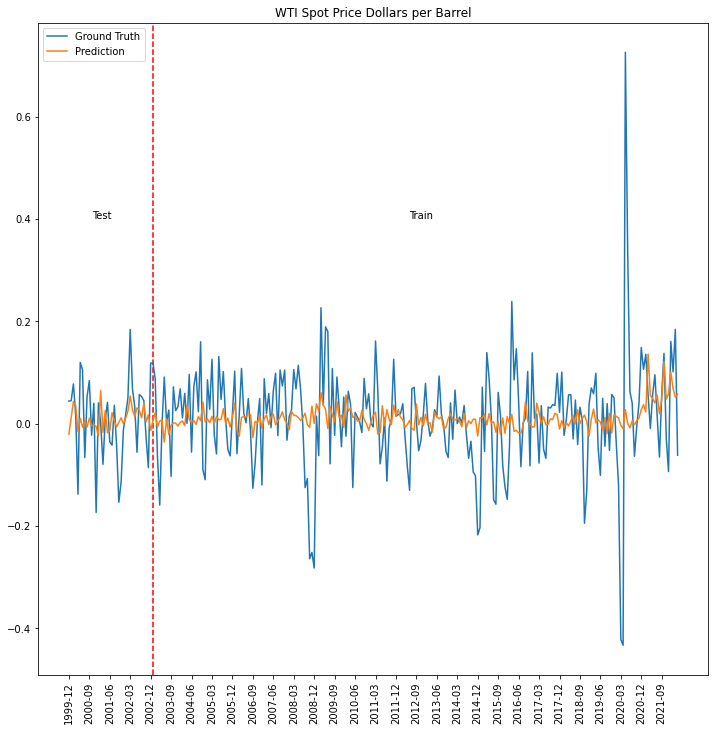

In [ ]:
outputs = model.predict(df)

data_predict = outputs[i:].reset_index(drop=True)
dataY_plot = df['WTI Spot Price Dollars per Barrel'][i:].reset_index(drop=True)

plt.figure(figsize=(12,12))

plt.axvline(x=len(test_df)-i, c='r', linestyle='--')

plt.plot(df.iloc[i:,0], dataY_plot, label="Ground Truth")
plt.plot(df.iloc[i:,0], data_predict, label="Prediction")

plt.xticks(np.arange(0, len(df.iloc[i:,0])+1, 9), rotation = 90)
plt.title('WTI Spot Price Dollars per Barrel')

# adding text inside the plot
plt.text(150, 0.4, 'Train')
plt.text(10, 0.4, 'Test')

plt.legend(loc='upper left')
plt.savefig("eco_prediction.jpg", dpi=300, bbox_inches='tight')
plt.show()

## Perform neural network analysis

In [ ]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [ ]:
# same data used in the econometric models
train_df = train_df[train_df.columns.difference(["Date"] + perfect_predictors)]
test_df = test_df[test_df.columns.difference(["Date"] + perfect_predictors)]

### Load and preprocess data

In [ ]:
def load_data(data_df, window=1, future=1, dynamic=True):
  if dynamic:
    data_raw_x = torch.tensor(data_df.values).type(torch.float32)
  else:
    data_raw_x = torch.tensor(data_df.drop('WTI Spot Price Dollars per Barrel', axis=1).values).type(torch.float32)

  data_raw_y = torch.tensor(data_df[['WTI Spot Price Dollars per Barrel']].values).type(torch.float32)
  x = []
  y = []

  assert len(data_raw_x) == len(data_raw_y)

  for index in range(len(data_raw_x) - window - future+1): 
      x.append(data_raw_x[index : index + window])
      y.append(data_raw_y[index + window + future-1])
  
  return torch.stack(x), torch.stack(y)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y

    def __len__(self):
        return self.train_x.shape[0]

    def __getitem__(self, idx):
        return self.train_x[idx], self.train_y[idx]

### Create model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim=24, hidden_dim=48, num_layers=1, p=0.5):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(p)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, future=0):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim, dtype=torch.float32)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim, dtype=torch.float32)
        
        x = self.linear(x)

        x = self.dropout(x)

        # propagate input through LSTM
        out, (h_out, c_out) = self.lstm(x, (h_0, c_0))

        x = self.fc(out[:, -1]).squeeze(dim=0)
        
        return x

### Create training procedure

In [ ]:
def set_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  cudnn.benchmark, cudnn.deterministic = (False, True)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # for Multi-GPU, exception safe

In [ ]:
window = 12
future = 1
dynamic = True

train_x, train_y = load_data(train_df, window=window, future=future, dynamic=dynamic)
test_x, test_y = load_data(test_df, window=window, future=future, dynamic=dynamic)

print("Train x shape: {}".format(train_x.shape))
print("Train y shape: {}".format(train_y.shape))

print("Train x shape: {}".format(test_x.shape))
print("Test y shape: {}".format(test_y.shape))

Train x shape: torch.Size([220, 12, 35])
Train y shape: torch.Size([220, 1])
Train x shape: torch.Size([36, 12, 35])
Test y shape: torch.Size([36, 1])


In [ ]:
num_epochs = 12000
batch_size = 32
learning_rate = 0.005

input_dim = train_x.shape[-1]
hidden_dim = 16
num_layers = 1
dropout = 0.3

set_seed()

model = LSTM(input_dim, hidden_dim, num_layers, dropout)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_x_loader = DataLoader(CustomDataset(train_x, train_y), batch_size=batch_size, shuffle=True)

best_loss = np.inf
best_model = {}


for epoch in range(num_epochs):

  model.train()

  for batch_x, batch_y in train_x_loader:
    outputs = model(batch_x)
    optimizer.zero_grad()

    loss = criterion(outputs, batch_y)
    loss.backward()

    optimizer.step()

  model.eval()

  outputs = model(test_x)
  test_loss = criterion(outputs, test_y).mean()
  if test_loss < best_loss:
    best_loss = test_loss
    best_model = model.state_dict()
    print(f"Best epoch: {epoch}, best test loss: {best_loss.item()}")

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, train loss: {round(loss.item(), 5)}, test loss: {round(test_loss.item(), 5)}")

Best epoch: 0, best test loss: 0.006430288311094046
Epoch: 0, train loss: 0.01145, test loss: 0.00643
Best epoch: 1, best test loss: 0.00613660691305995
Epoch: 100, train loss: 0.00237, test loss: 0.01848
Epoch: 200, train loss: 0.00167, test loss: 0.0155
Epoch: 300, train loss: 0.00084, test loss: 0.01316
Epoch: 400, train loss: 0.00049, test loss: 0.00985
Epoch: 500, train loss: 0.00087, test loss: 0.00941
Epoch: 600, train loss: 0.00038, test loss: 0.00765
Epoch: 700, train loss: 0.00048, test loss: 0.00727
Best epoch: 749, best test loss: 0.0059641581028699875
Epoch: 800, train loss: 0.0004, test loss: 0.00601
Best epoch: 802, best test loss: 0.005500684026628733
Epoch: 900, train loss: 0.00018, test loss: 0.00593
Best epoch: 927, best test loss: 0.005437888205051422
Best epoch: 931, best test loss: 0.005242481362074614
Epoch: 1000, train loss: 0.0004, test loss: 0.00573
Epoch: 1100, train loss: 0.00033, test loss: 0.00575
Epoch: 1200, train loss: 0.0003, test loss: 0.00627
Epoch: 

### Visually evaluate the performance

In [ ]:
data_x, data_y = load_data(pd.concat((test_df, train_df)), window=window, future=future, dynamic=dynamic)

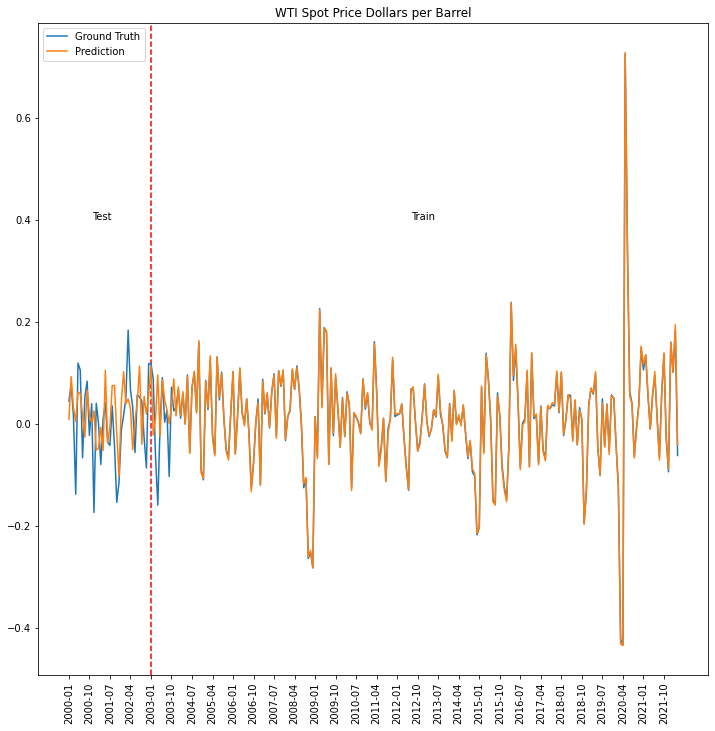

In [ ]:
model = LSTM(input_dim, hidden_dim, num_layers, dropout)
model.load_state_dict(best_model)

model.eval()

outputs = model(data_x)

data_predict = outputs.data.numpy()
dataY_plot = data_y.data.numpy()

plt.figure(figsize=(12,12))

plt.axvline(x=len(test_df)-window, c='r', linestyle='--')

plt.plot(df.iloc[window:,0], dataY_plot, label="Ground Truth")
plt.plot(df.iloc[window:,0], data_predict, label="Prediction")

plt.xticks(np.arange(0, len(df.iloc[window:,0])+1, 9), rotation = 90)
plt.title('WTI Spot Price Dollars per Barrel')

# adding text inside the plot
plt.text(150, 0.4, 'Train')
plt.text(10, 0.4, 'Test')

plt.legend(loc='upper left')
plt.savefig("nn_prediction.jpg", dpi=300, bbox_inches='tight')
plt.show()